# Blog 1: Structured Output with LangChain + OpenAI

## Introduction
In this blog post, we will explore how to produce structured output using LangChain with OpenAI. LangChain is a powerful framework that simplifies the integration of language models into various applications, enabling us to manage inputs and outputs, including structured data formats, with ease. We will apply these capabilities to an Urban Heat Island Analysis project, leveraging NASA’s EarthData API to access MODIS Land Surface Temperature (LST) data. Our goal is to dynamically adjust parameters to ensure high-quality data for our analysis.

### Objectives

By the end of this lesson, you will be able to:

1. Set up the initial parameters for a data analysis project.
2. Visualize selected regions using Plotly Express.
3. Use LangChain and OpenAI to dynamically adjust project parameters.
4. Produce structured output using Pydantic models and LangChain.

## 1. Initial Setup

First, we need to manually set parameters for our analysis, such as the city region, coordinates for urban and rural areas, and the time range. This serves as our starting point and ensures we have a baseline for our project.

In [ ]:
# Define the initial data parameters for the analysis
data_params = {
    'city_region_name': 'Houston, TX',  # Name of the city region
    'coordinates': {
        'urban': {'SW': [29.69193, -95.47998], 'NE': [29.90719, -95.2251]},  # Coordinates for the urban area
        'rural': {'SW': [30.5, -96.5], 'NE': [31.0, -96.0]}  # Coordinates for the rural area
    },
    'time': {
        'start': '2023-06-01T00:00:00Z',  # Start time for data collection
        'end': '2023-08-31T23:59:59Z'  # End time for data collection
    }
}
data_params

In this step, we specify the city region as Houston, TX, define the coordinates for both urban and rural areas, and set a time range for our analysis.


## 2. Visualizing Selected Regions:


Visualizing the selected regions helps us verify the accuracy of our coordinates. We use Plotly Express to generate sample points within the bounding boxes and plot them.

In [ ]:
import pandas as pd
import plotly.express as px

def generate_sample_points(sw, ne, num_points=10):
    """Generate sample points within a given bounding box."""
    latitudes = [sw[0] + i * (ne[0] - sw[0]) / (num_points - 1) for i in range(num_points)]
    longitudes = [sw[1] + i * (ne[1] - sw[1]) / (num_points - 1) for i in range(num_points)]
    return [(lat, lon) for lat in latitudes for lon in longitudes]

# Generate sample points for urban and rural areas
sampled_coordinates = []
for region, bounding_box in data_params['coordinates'].items():
    
    sample_points = generate_sample_points(bounding_box['SW'], bounding_box['NE'])
    for lat, lon in sample_points:
        sampled_coordinates.append({'Region': region, 'Latitude': lat, 'Longitude': lon})

# Convert the sample points to a DataFrame
coords_df = pd.DataFrame(sampled_coordinates)
coords_df.head(2)

In [ ]:
## Plot the region suggested
fig = px.scatter_mapbox(coords_df, lat="Latitude", lon="Longitude", color='Region',
                        # color_continuous_scale="Viridis", 
                        mapbox_style="carto-positron",
                        title=f"Preview of Selected Bounding Boxes for {data_params['city_region_name']}",
                        height=600, width=800)
## Update the layout
fig.update_layout(
    margin={"r":0, "l":0,'b':0, 't':100},# Remove left and right side margins
    legend={'orientation':"h", 'yanchor':"top", 'y':1.05, 'xanchor':"left", 'x':0}, # Move legend to top   
)
fig.show()

This visualization helps us confirm that the regions are correctly defined and prepares us for the next steps.


## 3. Getting New Suggested Parameters from OpenAI 

### Setting Up OpenAI + LangChain


Before using OpenAI’s API, we need to set up our environment. Follow these steps:



1. **Sign up for OpenAI's API:** 
   - Visit the [OpenAI website](https://www.openai.com) and sign up for an API key.



2. **Create a `.secret` folder in your home directory:**
   ```bash
   cd ~
   mkdir .secret
   ```

3. **Save your API key as a text file in the `.secret` folder:**
   - Open a text editor and paste your API key.
   - Save the file as `open-ai.txt` in the `.secret` folder. For example, you can use the following command in the terminal to create the file and save the API key:
   


4. **Export the key from the file to your `.bash_profile` or `.zshrc`:**
   - Open your `.bash_profile` for editing in VS Code:
   ```bash
   # If using bash
    code ~/.bash_profile

    # If using zsh, use: 
    code ~/.zshrc
    ```

- Add the following line to export the API key:
   ```bash
   export OPENAI_API_KEY=$(cat ~/.secret/open-ai.txt)
   ```
   
- Save the file and exit the editor 


After following these steps, your API key will be available in your environment variables as `OPENAI_API_KEY`.



**5.	Confirm the setup with Python to ensure the key is correctly loaded.**

You can confirm this with Python by importing the `os` module and checking the `os.environ` dictionary for 'OPENAI_API_KEY'.


In [ ]:
import os
'OPENAI_API_KEY' in os.environ  # Should return True if the key is correctly loaded


> Note: Do NOT display the value of your OPENAI_API_KEY. If you accidentally expose your API credentials, OpenAI will automatically deactivate them, causing any program or app that uses it to break. 

### Using LangChain with ChatGPT

LangChain is a versatile framework designed to simplify the integration of language models into various applications, enabling seamless management of inputs and outputs, including structured data formats.

 By leveraging LangChain, developers can efficiently implement advanced AI functionalities, such as function calling, tool calling, and JSON mode, ensuring consistent and reliable outputs tailored to specific needs. This framework facilitates the creation of sophisticated AI-driven solutions across different domains, making it an essential tool for modern AI development. 

In [ ]:
## Installing langchain
# !pip install -U langchain_openai langchain_core langchain_community pydantic

To consruct a chain using LangChain's newer LCEL (LangChain Execution Language) we need to define the following elements:
- The PromptTemplate
- The LLM model/Chat object.
- The OutputParser

#### LangChain's `PromptTemplate`

Prompt engineering/construction is vital for obtaining high-quality results from any Large Langauge Model (LLM). To get the best suggestions from the API, it is important to provide sufficient context in our prompt/query, while leaving the option to customize the prompt on-the-fly.

To do so, we will create a prompt_string that has our prompt plus a set of curly brackets around a `specs` variable, as-if it was an f-string ( but note that we are not actually using it as an f-string).

In [ ]:

prompt_string = """I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
Help me select the urban and rural regions and time, keeping the following in mind:
{specs}
"""
print(prompt_string)

We will use this prompt_string to construct a PromptTemplate object with LangChain, which will turn our f-string variable into a parameter that we pass in with our request. 

In [ ]:
from langchain_core.prompts import PromptTemplate

# Converting the prompt_string to a PromptTemplate
prompt = PromptTemplate.from_template(prompt_string) 
prompt

In [ ]:
# Any f-string variables in the prompt string become input_variables.
prompt.input_variables

In [ ]:
# The prompt string with the f-string variables replaced by the input values using the .format() method
specs_string= "1. Urban area should be within the city limits and rural area should be outside the city limits."
print(prompt.format(specs=specs_string))

#### Instantiating an LLM

Next, we need to instantiate a language model. LangChain has separate packages for each of the LLMs it is compatible with. Since we are using OpenAI, we will use the ChatOpenAI object from `langchain_openai`. The ChatOpenAI object from LangChain will interact with the OpenAI API.

In [ ]:
from langchain_openai import ChatOpenAI 
chat = ChatOpenAI(api_key=os.environ['OPENAI_API_KEY'], model="gpt-4o", temperature=0.0)
chat

Setting the temperature to 0.0 ensures that the responses are deterministic and consistent.


#### Adding an Output Parser

The final piece of our chain is the output parser. While we could technically leave this out of our chain, it is better that we use the default StrOutputParser to convert our response into a simple string (instead of a JSON-like dictionary).

In [ ]:
from langchain_core.output_parsers import StrOutputParser
output_parser = StrOutputParser()

### 4. Putting it All Together: Our First Chain

We construct the final chain using the prompt, LLM, and output parser. This chain allows us to query OpenAI for new parameters.


Our chain starts with the prompt, followed by a pipe symbol `|` and then the LLM object, followed by another pipe, and finally the output parser. 

In [ ]:
# Constructing Our Chain
chain = prompt | chat | output_parser
chain

To use the chain we use the .invoke method and must provide the `input_variables` that are required by the prompt template.

In [ ]:
# Using the input variables to provide the necessary information
specs_string = """1. Urban area should be within the city limits and rural area should be outside the city limits.
2. The urban area should be selected within the southern US region to study the urban heat island effect. 
"""

# Invoke the chain to get the response
response = chain.invoke({'specs':specs_string})
print(response)

In [ ]:
# ChatGPT responds with Markdown-stytled text, so we can use IPython's `Markdown` class to render it
from IPython.display import Markdown, display
# display(Markdown(response))

To leverage the new suggestions from ChatGPT, we would have to manually construct a new `data_params` dict using the raw text from the response. This is a manual process that can be automated by using a more complex Output Parser: the Json.

### 5. Getting Structured Output from LangChain

#### Structured Output

We aim to produce a JSON-dictionary with the same structure as our original data_params. To achieve this, we define a Pydantic data model.

In [ ]:
## Defining the structured output desired from chat gpt
from pydantic import BaseModel, Field
from typing import List, Optional, Text, Dict
from langchain_core.output_parsers import JsonOutputParser

# Define Pydantic models for structured output
class Coordinates(BaseModel):
    SW: List[float]
    NE: List[float]

class RegionCoordinates(BaseModel):
    rural: Optional[Coordinates]
    urban: Optional[Coordinates]

class DataParams(BaseModel):
    city_region_name: str
    coordinates: Optional[RegionCoordinates]
    time: Dict[str, str]



We will insert a new input_variable in our PromptTempalte for the format_instructions, which will be filled in as a partial prompt using `prompt.partial().`

In [ ]:
from langchain_core.prompts import PromptTemplate

# Define the prompt template for the language model
prompt_string = """
I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas.
I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
Help me select the urban and rural regions and time, keeping the following in mind:
{specs}

Format Instructions:
{format_instructions}
"""
prompt = PromptTemplate.from_template(prompt_string)

# Define the output parser with the Pydantic model
output_parser = JsonOutputParser(pydantic_object=DataParams)

# Update the prompt template to include format instructions for JSON output
prompt = prompt.partial(format_instructions=output_parser.get_format_instructions())

# Construct the chain using the prompt, language model, and output parser
chain = prompt | chat | output_parser

# Define the specifications for the query

specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset.
Do not select a city in the desert or near a large body of water."""

# Invoke the chain to get the response in structured format
data_params = chain.invoke({'specs': specs})
data_params # Print the structured response from the language model

This structured output can be directly used to adjust our parameters for the Urban Heat Island Analysis project.


In [ ]:
# Generate sample points for urban and rural areas
sampled_coordinates = []
for region, bounding_box in data_params['coordinates'].items():
    sample_points = generate_sample_points(bounding_box['SW'], bounding_box['NE'])
    for lat, lon in sample_points:
        sampled_coordinates.append({'Region': region, 'Latitude': lat, 'Longitude': lon})

# Convert the sample points to a DataFrame
coords_df = pd.DataFrame(sampled_coordinates)

## Plot the region suggested
fig = px.scatter_mapbox(coords_df, lat="Latitude", lon="Longitude", color='Region',
                        # color_continuous_scale="Viridis", 
                        mapbox_style="carto-positron",
                        title=f"Preview of Selected Bounding Boxes for {data_params['city_region_name']}",
                        height=600, width=800)
## Update the layout
fig.update_layout(
    margin={"r":0, "l":0,'b':0, 't':100},# Remove left and right side margins
    legend={'orientation':"h", 'yanchor':"top", 'y':1.05, 'xanchor':"left", 'x':0}, # Move legend to top   
)
fig.show()

## Conclusion

Using LangChain with OpenAI allows us to dynamically adjust parameters and obtain structured outputs, significantly improving our data analysis workflow. This setup can be adapted for various projects requiring precise and structured data retrieval. By automating the parameter selection process, we can ensure high-quality data and streamline our analysis.

Feel free to reach out with questions or feedback, and stay tuned for more advanced tutorials!


___

# APPENDIX

In [ ]:
# raise Exception("Stop here")

### Created a function that asks ChatGPT for suggested parameters

In [ ]:
def suggest_data_params(specs: str, temperature=0.0, model_type='gpt-4o', return_json=True) -> str:
    """
    Suggests data parameters for downloading MODIS data for a specific region and time range.
    
    Args:
        query (str): The query describing the requirements for the data download.
        temperature (float, optional): The temperature parameter for the language model. Defaults to 0.1.
        model_type (str, optional): The type of language model to use. Defaults to 'gpt-4o'.
        return_llm (bool, optional): Whether to return the language model chain. Defaults to False.
        return_json (bool, optional): Whether to return the response as JSON. Defaults to True.
    
    Returns:
        str: The response from the language model chain or the JSON response, depending on the value of return_json.
    """
    
    # The prompt template for suggesting data parameters
    prompt = """
    I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
    I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
    Help me select the urban and rural regions and time following the instructions below.
    {specs}
    
    Provide me the data parameters for the download (city_region_name, coordinates as SW [lat,long] NE [lat,long], time_start named 'start', time_end named 'end') in the following format:
    Format Instructions:
    Use the 2-letter abbreviations for the state.
    {format_instructions}
    """
    # Create a ChatPromptTemplate object
    final_prompt_template = PromptTemplate.from_template(prompt)

    # Get api key for OpenAI from the environment or session state (if on Streamlit)
    api_key = os.getenv('OPENAI_API_KEY')
        
    # Instantiate the language model and setting the specific model (chat-gpto is newest and reasonable price)
    # and  set the temperature (creativity level)
    llm = ChatOpenAI(temperature=temperature, model=model_type, api_key=api_key)
    
    if return_json:
        # # JsonOutputParser will use the data model classes from above
        parser = JsonOutputParser(pydantic_object=DataParams,)    
        # Add formatting instructions for pydantic
        instructions =  parser.get_format_instructions()
            
    else:
        ## StrOutputParser will return the response as a string
        parser = StrOutputParser(output_key="response")
        # Manually defining the format instructions
        instructions = "Respond with text for each topic as a nested list with the topic number,  descriptive label,top words, and short insight."
        
        
    ## Adding the instructions to the prompt template
    final_prompt_template = final_prompt_template.partial(format_instructions=instructions)
    
    
    # Making the final chain
    llm_chain = final_prompt_template | llm | parser
    
    # Invoke the chain with the query to get the response
    return llm_chain.invoke(input=dict(specs=specs))

In [ ]:

# specs = """Select a region that will be a perfect example of the effects of urban heat islands.
# Select identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset.
# """

# # ask ChatGPT to suggest another set of parameters
# chatgpt_params = suggest_data_params(specs=specs, 
#                                     return_json=True, temperature=0.0)
# chatgpt_params

In [ ]:
def preview_regions(data_params):
    

    # Dataframe to store results
    sampled_coordinates = []

    # Check if any coordinates within the bounding boxes are over sea
    for region, bounding_box in data_params['coordinates'].items():
        # Generate sample points within the bounding box
        sample_points = generate_sample_points(bounding_box['SW'], bounding_box['NE'], num_points=10)
        for lat, lon in sample_points:
            sampled_coordinates.append({'Region': region, 'Latitude': lat, 'Longitude': lon})

    # Convert results to DataFrame
    coords_df = pd.DataFrame(sampled_coordinates)
    
    
        ## Plot the region suggested
    fig = px.scatter_mapbox(coords_df, lat="Latitude", lon="Longitude", color='Region',
                            # color_continuous_scale="Viridis", 
                            mapbox_style="carto-positron",
                            title=f"Preview of Selected Bounding Boxes for {data_params['city_region_name']}",
                            height=600, width=600)

    # Remove left and right side margins
    fig.update_layout(
        margin={"r":0, "l":0,'b':0, 't':100},
        legend={'orientation':"h", 'yanchor':"top", 'y':1.05, 'xanchor':"left", 'x':0},
        
    )

    return fig
    ## Save fig for README
    # fig.write_image(f"{img_dir}selected_regions.png")
    
# preview_regions(chatgpt_params)

In [ ]:

specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select small identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset.
Select a region in a non-desert area."""

# ask ChatGPT to suggest another set of parameters
chatgpt_params = suggest_data_params(specs=specs, 
                                    return_json=True, temperature=0.0)
print(chatgpt_params)
preview_regions(chatgpt_params)

And then we can use these new data_params to download the NASA Earth Science data, which will be covered in a later blog post. 


### CENSUS Data

In [ ]:
import requests
import json
import pandas as pd


url = "https://api.census.gov/data/2022/acs/acs5/variables.json"

temp_df = pd.read_json(url)
df_variables = pd.json_normalize(temp_df['variables'])
df_variables.index = temp_df.index
df_variables = df_variables.reset_index()
df_variables

In [ ]:
df_variables.to_csv('census_variables.csv', index=False)

In [ ]:
import os
creds_file = "/Users/codingdojo/.secret/census.json"
with open(os.path.abspath(creds_file)) as f:
    creds = json.load(f)
    api_key = creds['api-key']

Example API Queries
https://api.census.gov/data/2022/acs/acs5/subject/examples.html 

To retrieve data for every census tract in Georgia using the American Community Survey (ACS) API, you'll need to make use of the U.S. Census Bureau's API. Below, I’ll guide you through the process, including how to access the API, construct your query, and extract the data for analysis.

### Step 1: Understanding the ACS API

The ACS API allows you to access a wide range of demographic, economic, and housing data. For this example, we'll focus on the ACS 5-Year estimates, which provide detailed information at smaller geographic levels like census tracts.

### Step 2: Obtain an API Key

Before using the Census API, you need to obtain an API key from the Census Bureau:

1. Visit the [Census Bureau's API Key Request page](https://api.census.gov/data/key_signup.html).
2. Fill out the form to request a key. The key will be sent to your email.

### Step 3: Construct the API Request

You'll need to construct a URL to query the API. The URL includes several parameters:

- **Base URL:** The endpoint for the ACS 5-Year Data.
- **Variables:** The specific data points you want to retrieve (e.g., total population, median household income).
- **Geography:** Specify the geographic level (e.g., state, county, tract).
- **Year:** The year of the ACS data you're interested in.
- **State and County Codes:** To filter results specifically for Georgia census tracts.

Here’s a general structure of the API request:

```
https://api.census.gov/data/20XX/acs/acs5?get=VARIABLES&for=tract:*&in=state:13&key=YOUR_API_KEY
```

- Replace `20XX` with the year you're interested in (e.g., `2022` for the latest data).
- Replace `VARIABLES` with a comma-separated list of variables you're interested in.
- `state:13` is the FIPS code for Georgia.



### Step 4: Identify the Variables You Want

You can find a list of available variables in the [ACS Data Dictionary](https://api.census.gov/data/2022/acs/acs5/variables.html). Commonly used variables include:

- **B01003_001E:** Total population.
- **B19013_001E:** Median household income.
- **B25077_001E:** Median home value.

### Step 5: Fetch the Data Using Python

Here's how you can use Python to fetch the data:

```python
import requests
import pandas as pd

# Define the parameters
year = "2022"
variables = "B01003_001E,B19013_001E,B25077_001E"
state_fips = "13"  # FIPS code for Georgia
api_key = "YOUR_API_KEY"

# Construct the API URL
url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{variables}&for=tract:*&in=state:{state_fips}&key={api_key}"

# Make the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Convert the data to a pandas DataFrame
    columns = data[0]
    rows = data[1:]
    df = pd.DataFrame(columns=columns, data=rows)

    # Rename columns for better readability
    df = df.rename(columns={
        "B01003_001E": "Total Population",
        "B19013_001E": "Median Household Income",
        "B25077_001E": "Median Home Value"
    })

    # Display the DataFrame
    import ace_tools as tools; tools.display_dataframe_to_user(name="ACS Data for Georgia Census Tracts", dataframe=df)
else:
    print("Error fetching data:", response.status_code)
```

### Step 6: Analyze and Use the Data

Once you have the data in a pandas DataFrame, you can analyze it, visualize it, or merge it with other datasets for further analysis.

### Explanation of the Code

- **API URL Construction:** The URL is constructed using the desired year, variables, and geographic filters. The wildcard `tract:*` specifies that you want data for all tracts in Georgia.
- **Response Parsing:** The API response is in JSON format, and we parse it into a DataFrame for easy manipulation.
- **Data Cleaning:** We rename the columns to make them more descriptive.

### Additional Tips

- **Explore More Variables:** Use the [ACS Variables List](https://api.census.gov/data/2022/acs/acs5/variables.html) to find more variables you might be interested in.
- **Error Handling:** Incorporate error handling to manage cases where the API might not return data successfully.
- **Rate Limiting:** Be mindful of the Census API's rate limits and structure your requests accordingly.

This approach will help you obtain and analyze ACS data for every census tract in Georgia. Let me know if you have any questions or need further assistance!

To analyze socioeconomic differences between regions that are part of an urban heat island (UHI) and those that are not, you can select a variety of variables from the American Community Survey (ACS) that reflect the socioeconomic status, housing characteristics, and demographic profiles of these areas. Here are some key variables that would be useful for this type of analysis:

### Key Socioeconomic Variables

1. **Income and Poverty:**
   - **Median Household Income:** (`B19013_001E`) - Reflects the overall economic status of households.
   - **Per Capita Income:** (`B19301_001E`) - Provides insight into the average income per person in an area.
   - **Percentage of Population Below Poverty Level:** (`B17021_002E / B17021_001E`) - Indicates economic hardship and poverty prevalence.

2. **Employment and Education:**
   - **Unemployment Rate:** (`B23025_005E / B23025_002E`) - Measures the percentage of the labor force that is unemployed.
   - **Educational Attainment:** 
     - **Percentage with High School Diploma or Higher:** (`B15003_017E to B15003_025E`)
     - **Percentage with Bachelor's Degree or Higher:** (`B15003_022E to B15003_025E`) - Highlights educational disparities.

3. **Housing Characteristics:**
   - **Median Home Value:** (`B25077_001E`) - Reflects the economic conditions and housing market.
   - **Median Gross Rent:** (`B25064_001E`) - Provides insight into rental market dynamics.
   - **Percentage of Owner-Occupied Housing Units:** (`B25003_002E / B25003_001E`) - Indicates housing stability and investment.

4. **Demographic and Social Characteristics:**
   - **Race and Ethnicity:**
     - **Percentage of Population by Race:** (`B02001_002E` for White, `B02001_003E` for Black or African American, etc.)
     - **Percentage of Hispanic or Latino Origin:** (`B03003_003E`) - Identifies racial and ethnic diversity.
   - **Age Distribution:**
     - **Median Age:** (`B01002_001E`) - Provides demographic insights into age-related vulnerabilities.
   - **Language Spoken at Home:**
     - **Percentage of Non-English Speakers:** (`B16001_002E to B16001_006E`) - Highlights linguistic diversity and potential barriers.

5. **Transportation and Access:**
   - **Means of Transportation to Work:**
     - **Percentage Using Public Transit:** (`B08301_010E / B08301_001E`) - Indicates reliance on public transportation.
   - **Access to Vehicles:**
     - **Percentage of Households with No Vehicle Available:** (`B25044_003E / B25044_001E`) - Reflects access to transportation resources.

### Analysis Approach

To effectively analyze these variables in the context of urban heat islands, consider the following steps:

1. **Data Collection:**
   - Use the ACS API or download data directly from the [U.S. Census Bureau's data portal](https://data.census.gov/) for the relevant variables and geographic regions.

2. **Define Urban Heat Island Areas:**
   - Utilize geospatial analysis to identify areas that are part of urban heat islands. This may involve using satellite data (e.g., NASA MODIS LST) to identify temperature anomalies in urban areas.

3. **Spatial Analysis:**
   - Overlay socioeconomic data with urban heat island data using GIS software like QGIS or ArcGIS.
   - Use spatial joins to associate census tracts with UHI data.

4. **Comparative Analysis:**
   - Compare socioeconomic indicators between UHI areas and non-UHI areas using statistical methods.
   - Conduct t-tests, chi-square tests, or regression analysis to identify significant differences or correlations.

5. **Visualization:**
   - Create maps and charts to visually represent socioeconomic disparities.
   - Use heat maps, bar charts, and scatter plots to highlight key findings.

### Example Python Code for Data Retrieval

Here's how you might use Python to retrieve some of these variables from the ACS API:


In [ ]:
import requests
import pandas as pd

# Variables to retrieve
vars_to_retrieve = {
        "B19013_001E": "Median Household Income",
        "B19301_001E": "Per Capita Income",
        "B17021_002E": "Population Below Poverty Level",
        "B17021_001E": "Total Population for Poverty",
        "B23025_005E": "Unemployed Population",
        "B23025_002E": "Labor Force Population",
        "B15003_017E": "High School Graduate",
        "B15003_022E": "Bachelor's Degree or Higher",
        "B25077_001E": "Median Home Value",
        "B25064_001E": "Median Gross Rent",
        "B25003_002E": "Owner Occupied Housing Units",
        "B25003_001E": "Total Housing Units",
        "B02001_002E": "White Population",
        "B02001_003E": "Black or African American Population",
        "B03003_003E": "Hispanic or Latino Population",
        "B01002_001E": "Median Age",
        "B16001_002E": "Non-English Speakers",
        "B08301_010E": "Public Transit Commuters",
        "B08301_001E": "Total Commuters",
        "B25044_003E": "Households with No Vehicle",
        "B25044_001E": "Total Households"
    }



# Define parameters
year = "2022"
# variables = "B19013_001E,B19301_001E,B17021_002E,B17021_001E,B23025_005E,B23025_002E,B15003_017E,B15003_022E,B25077_001E,B25064_001E,B25003_002E,B25003_001E,B02001_002E,B02001_003E,B03003_003E,B01002_001E,B16001_002E,B08301_010E,B08301_001E,B25044_003E,B25044_001E"
variables = ",".join(vars_to_retrieve.keys())
state_fips = "13"  # FIPS code for Georgia
api_key = api_key

# Construct API URL
url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{variables}&for=tract:*&in=state:{state_fips}&key={api_key}"

# Make API request
response = requests.get(url)
response.status_code

In [ ]:

# Check if request was successful
if response.status_code == 200:
    # Parse JSON response
    data = response.json()

    # Convert data to pandas DataFrame
    columns = data[0]
    rows = data[1:]
    df = pd.DataFrame(columns=columns, data=rows)

    # Rename columns for readability
    df = df.rename(columns={
        "B19013_001E": "Median Household Income",
        "B19301_001E": "Per Capita Income",
        "B17021_002E": "Population Below Poverty Level",
        "B17021_001E": "Total Population for Poverty",
        "B23025_005E": "Unemployed Population",
        "B23025_002E": "Labor Force Population",
        "B15003_017E": "High School Graduate",
        "B15003_022E": "Bachelor's Degree or Higher",
        "B25077_001E": "Median Home Value",
        "B25064_001E": "Median Gross Rent",
        "B25003_002E": "Owner Occupied Housing Units",
        "B25003_001E": "Total Housing Units",
        "B02001_002E": "White Population",
        "B02001_003E": "Black or African American Population",
        "B03003_003E": "Hispanic or Latino Population",
        "B01002_001E": "Median Age",
        "B16001_002E": "Non-English Speakers",
        "B08301_010E": "Public Transit Commuters",
        "B08301_001E": "Total Commuters",
        "B25044_003E": "Households with No Vehicle",
        "B25044_001E": "Total Households"
    })

    # Calculate derived variables
    df['Poverty Rate'] = df['Population Below Poverty Level'].astype(float) / df['Total Population for Poverty'].astype(float) * 100
    df['Unemployment Rate'] = df['Unemployed Population'].astype(float) / df['Labor Force Population'].astype(float) * 100
    df['Percentage Owner Occupied'] = df['Owner Occupied Housing Units'].astype(float) / df['Total Housing Units'].astype(float) * 100
    df['Percentage Public Transit'] = df['Public Transit Commuters'].astype(float) / df['Total Commuters'].astype(float) * 100
    df['Percentage No Vehicle'] = df['Households with No Vehicle'].astype(float) / df['Total Households'].astype(float) * 100

else:
    print("Error fetching data:", response.status_code)

In [ ]:
df

In [ ]:

    # # Display the DataFrame
    # import ace_tools as tools; tools.display_dataframe_to_user(name="ACS Data for Georgia Census Tracts", dataframe=df)




### Conclusion

By selecting these socioeconomic variables, you can gain insights into how urban heat islands affect communities differently based on their economic status, housing characteristics, and demographic profiles. This analysis can inform urban planning, policy-making, and interventions to address vulnerabilities related to heat exposure. Let me know if you need further assistance!

## Updated ChatGPT Data Model to include Census Tract FIPS

In [ ]:
## Defining the structured output desired from chat gpt
from pydantic import BaseModel, Field
from typing import List, Optional, Text, Dict
from langchain_core.output_parsers import JsonOutputParser

# Define Pydantic models for structured output
class Coordinates(BaseModel):
    SW: List[float]
    NE: List[float]

class RegionCoordinates(BaseModel):
    rural: Optional[Coordinates]
    urban: Optional[Coordinates]


class FIPS(BaseModel):
    state_fips: str
    county_fips: List[str]
    census_tract_fips: List[str]
    # urban_census_tract_fips: List[str]
class RegionFIPS(BaseModel):
    state_fips: str
    # rural_census_tract_fips: List[str]
    rural: Optional[FIPS]
    urban: Optional[FIPS]
    # urban_census_tract_fips: List[str]

class DataParamsFips(BaseModel):
    city_region_name: str
    coordinates: Optional[RegionCoordinates]
    time: Dict[str, str]
    fips: Optional[RegionFIPS]


In [ ]:
def suggest_data_params(specs: str, temperature=0.0, model_type='gpt-4o', return_json=True,
                        pydantic_model=DataParamsFips) -> str:
    """
    Suggests data parameters for downloading MODIS data for a specific region and time range.
    
    Args:
        query (str): The query describing the requirements for the data download.
        temperature (float, optional): The temperature parameter for the language model. Defaults to 0.1.
        model_type (str, optional): The type of language model to use. Defaults to 'gpt-4o'.
        return_llm (bool, optional): Whether to return the language model chain. Defaults to False.
        return_json (bool, optional): Whether to return the response as JSON. Defaults to True.
    
    Returns:
        str: The response from the language model chain or the JSON response, depending on the value of return_json.
    """
    
    # The prompt template for suggesting data parameters
    prompt = """
    I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
    I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
    Help me select the urban and rural regions and time following the instructions below.
    {specs}
    
    Provide me the data parameters for the download (city_region_name, coordinates as SW [lat,long] NE [lat,long], time_start named 'start', time_end named 'end') 
    also include the state FIPS and a list of every census tract fips code included within the selected regions for the Census API, in the following format:
    Format Instructions:
    Use the 2-letter abbreviations for the state.
    {format_instructions}
    """
    # Create a ChatPromptTemplate object
    final_prompt_template = PromptTemplate.from_template(prompt)

    # Get api key for OpenAI from the environment or session state (if on Streamlit)
    api_key = os.getenv('OPENAI_API_KEY')
        
    # Instantiate the language model and setting the specific model (chat-gpto is newest and reasonable price)
    # and  set the temperature (creativity level)
    llm = ChatOpenAI(temperature=temperature, model=model_type, api_key=api_key)
    
    if return_json:
        # # JsonOutputParser will use the data model classes from above
        parser = JsonOutputParser(pydantic_object=pydantic_model,)    
        # Add formatting instructions for pydantic
        instructions =  parser.get_format_instructions()
            
    else:
        ## StrOutputParser will return the response as a string
        parser = StrOutputParser(output_key="response")
        # Manually defining the format instructions
        instructions = "Respond with text for each topic as a nested list with the topic number,  descriptive label,top words, and short insight."
        
        
    ## Adding the instructions to the prompt template
    final_prompt_template = final_prompt_template.partial(format_instructions=instructions)
    
    
    # Making the final chain
    llm_chain = final_prompt_template | llm | parser
    
    # Invoke the chain with the query to get the response
    return llm_chain.invoke(input=dict(specs=specs))

In [ ]:

specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select small identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset.
Select a region in a non-desert area."""

chatgpt_params = suggest_data_params(specs=specs,pydantic_model=DataParamsFips, return_json=True, temperature=0.0)
chatgpt_params

In [ ]:
# import requests
# import pandas as pd

# def fetch_acs_data(tract_fips_codes, variables=None, year="2022", api_key="YOUR_API_KEY"):
#     """
#     Fetches ACS data for specified census tracts.

#     Parameters:
#     - tract_fips_codes (list of str): List of 11-digit FIPS codes for census tracts.
#     - variables (str): Comma-separated list of ACS variables to retrieve.
#     - year (str): Year of the ACS data (default is "2022").
#     - api_key (str): Your Census API key.

#     Returns:
#     - DataFrame: A pandas DataFrame containing the requested ACS data for the specified tracts.
#     """
    
#     # Variables to retrieve
#     vars_to_retrieve = {
#             "B19013_001E": "Median Household Income",
#             "B19301_001E": "Per Capita Income",
#             "B17021_002E": "Population Below Poverty Level",
#             "B17021_001E": "Total Population for Poverty",
#             "B23025_005E": "Unemployed Population",
#             "B23025_002E": "Labor Force Population",
#             "B15003_017E": "High School Graduate",
#             "B15003_022E": "Bachelor's Degree or Higher",
#             "B25077_001E": "Median Home Value",
#             "B25064_001E": "Median Gross Rent",
#             "B25003_002E": "Owner Occupied Housing Units",
#             "B25003_001E": "Total Housing Units",
#             "B02001_002E": "White Population",
#             "B02001_003E": "Black or African American Population",
#             "B03003_003E": "Hispanic or Latino Population",
#             "B01002_001E": "Median Age",
#             "B16001_002E": "Non-English Speakers",
#             "B08301_010E": "Public Transit Commuters",
#             "B08301_001E": "Total Commuters",
#             "B25044_003E": "Households with No Vehicle",
#             "B25044_001E": "Total Households"
#         }
#     variables= ",".join(vars_to_retrieve.keys())

#     # Initialize a list to store data
#     data_list = []

#     # Loop over each FIPS code
#     for fips_code in tract_fips_codes:
#         # Extract state, county, and tract components
#         state_fips = fips_code[:2]
#         county_fips = fips_code[2:5]
#         tract_code = fips_code[5:]

#         # Construct the API URL for the specific tract
#         # url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{variables}&for=tract:{tract_code}&in=state:{state_fips}+county:{county_fips}&key={api_key}"
#         # url =  f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{variables}&for=tract:{tract_code}&in=state:{state_fips}%20county:{county_fips}&key={api_key}"
        
#         # Make the API request
#         # response = requests.get(url)
        
#         # Define the parameters for the API request
#         params = {
#             "get": f"NAME,{variables}",
#             "for": f"tract:{tract_code}",
#             "in": f"state:{state_fips} county:{county_fips}",
#             "key": api_key
#         }

#         # Base URL for the ACS API
#         url = f"https://api.census.gov/data/{year}/acs/acs5"

#         # Make the API request
#         response = requests.get(url, params=params)

#         # Check if the request was successful
#         if response.status_code == 200:
#             # Parse the JSON response
#             data = response.json()

#             # Append the data (skipping header row)
#             if len(data) > 1:
#                 data_list.append(data[1])
#         else:
#             print(f"Error fetching data for tract {fips_code}: {response.status_code}")

#     # Convert the collected data to a pandas DataFrame
#     if data_list:
#         columns = data[0]
#         df = pd.DataFrame(columns=columns, data=data_list)

#         # Rename columns for better readability
#         df = df.rename(columns=vars_to_retrieve)

#         # Calculate derived variables
#         try:
#             df['Poverty Rate'] = df['Population Below Poverty Level'].astype(float) / df['Total Population for Poverty'].astype(float) * 100
#             df['Unemployment Rate'] = df['Unemployed Population'].astype(float) / df['Labor Force Population'].astype(float) * 100
#             df['Percentage Owner Occupied'] = df['Owner Occupied Housing Units'].astype(float) / df['Total Housing Units'].astype(float) * 100
#             df['Percentage Public Transit'] = df['Public Transit Commuters'].astype(float) / df['Total Commuters'].astype(float) * 100
#             df['Percentage No Vehicle'] = df['Households with No Vehicle'].astype(float) / df['Total Households'].astype(float) * 100
#         except KeyError as e:
#             print(f"KeyError: {e}. Unable to calculate derived variables.")
#         return df

#     else:
#         print("No data was fetched. Please check your FIPS codes or API request parameters.")
#         return pd.DataFrame()  # Return an empty DataFrame in case of failure


In [ ]:
import requests
import pandas as pd

def fetch_acs_data(tract_fips_codes, variables, year="2022", api_key="YOUR_API_KEY"):
    """
    Fetches ACS data for specified census tracts.

    Parameters:
    - tract_fips_codes (list of str): List of 11-digit FIPS codes for census tracts.
    - variables (str): Comma-separated list of ACS variables to retrieve.
    - year (str): Year of the ACS data (default is "2022").
    - api_key (str): Your Census API key.

    Returns:
    - DataFrame: A pandas DataFrame containing the requested ACS data for the specified tracts.
    """
    # Initialize a list to store data
    data_list = []

    # Loop over each FIPS code
    for fips_code in tract_fips_codes:
        
        # Extract state, county, and tract components
        state_fips = fips_code[:2]
        county_fips = fips_code[2:5]
        tract_code = fips_code[5:]

        fips_data = [ ]
        
        for var in variables.split(','):

            # Construct the API URL for the specific tract
            # url = f"https://api.census.gov/data/{year}/acs/acs5/subject?get=NAME,{variables}&for=tract:{tract_code}&in=state:{state_fips}+county:{county_fips}&key={api_key}"
            url =  f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{var}&for=tract:{tract_code}&in=state:{state_fips}%20county:{county_fips}&key={api_key}"
            # Make the API request
            response = requests.get(url)

            # Check if the request was successful
            if response.status_code == 200:
                # Parse the JSON response
                data = response.json()

                # Append the data (skipping header row)
                if len(data) > 1:
                    # data_list.append(data[1])
                    fips_data.append(data[1])
                else:
                    data = ""
            data_list.append(fips_data)
        else:
            print(f"Error fetching data for tract {fips_code}: {response.status_code}")
            print(f"URL: {url}")

    # Convert the collected data to a pandas DataFrame
    if data_list:
        try:
            columns = data[0]
            df = pd.DataFrame(columns=columns, data=data_list)

            # Rename columns for better readability
            df = df.rename(columns={
                "B19013_001E": "Median Household Income",
                "B19301_001E": "Per Capita Income",
                "B17021_002E": "Population Below Poverty Level",
                "B17021_001E": "Total Population for Poverty",
                "B23025_005E": "Unemployed Population",
                "B23025_002E": "Labor Force Population",
                "B15003_017E": "High School Graduate",
                "B15003_022E": "Bachelor's Degree or Higher",
                "B25077_001E": "Median Home Value",
                "B25064_001E": "Median Gross Rent",
                "B25003_002E": "Owner Occupied Housing Units",
                "B25003_001E": "Total Housing Units",
                "B02001_002E": "White Population",
                "B02001_003E": "Black or African American Population",
                "B03003_003E": "Hispanic or Latino Population",
                "B01002_001E": "Median Age",
                "B16001_002E": "Non-English Speakers",
                "B08301_010E": "Public Transit Commuters",
                "B08301_001E": "Total Commuters",
                "B25044_003E": "Households with No Vehicle",
                "B25044_001E": "Total Households"
            })

            # Calculate derived variables
            df['Poverty Rate'] = df['Population Below Poverty Level'].astype(float) / df['Total Population for Poverty'].astype(float) * 100
            df['Unemployment Rate'] = df['Unemployed Population'].astype(float) / df['Labor Force Population'].astype(float) * 100
            df['Percentage Owner Occupied'] = df['Owner Occupied Housing Units'].astype(float) / df['Total Housing Units'].astype(float) * 100
            df['Percentage Public Transit'] = df['Public Transit Commuters'].astype(float) / df['Total Commuters'].astype(float) * 100
            df['Percentage No Vehicle'] = df['Households with No Vehicle'].astype(float) / df['Total Households'].astype(float) * 100

            return df
        except:
            print("Error converting data to DataFrame.")
            return data_list

    else:
        print("No data was fetched. Please check your FIPS codes or API request parameters.")
        return pd.DataFrame()  # Return an empty DataFrame in case of failure


In [ ]:

# # Example usage:
# tract_fips_codes = [
#     "13051000100",  # Example FIPS codes
#     "13051000200",
#     # Add more FIPS codes as needed
# ]

# variables = "B19013_001E,B19301_001E,B17021_002E,B17021_001E,B23025_005E,B23025_002E,B15003_017E,B15003_022E,B25077_001E,B25064_001E,B25003_002E,B​⬤

In [ ]:

specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select small identically-sized nearby non-overlapping regions from the selected area to minimize the size of the dataset."""
# Select a region in a non-desert area."""

chatgpt_params = suggest_data_params(specs=specs,pydantic_model=DataParamsFips, return_json=True, temperature=0.0)
chatgpt_params

In [ ]:
df_urban = fetch_acs_data(chatgpt_params['fips']['urban']['census_tract_fips'], api_key=api_key)

In [ ]:
chatgpt_params['fips']['urban']['census_tract_fips']

In [ ]:
df_urban = fetch_acs_data(chatgpt_params['fips']['urban']['census_tract_fips'], api_key=api_key)

In [ ]:
chatgpt_params['fips']['urban']

In [ ]:
tract_fips_codes = chatgpt_params['fips']['urban']['census_tract_fips']
tract_fips_codes

In [ ]:
vars_to_retrieve = {
            "B19013_001E": "Median Household Income",
            "B19301_001E": "Per Capita Income",
            "B17021_002E": "Population Below Poverty Level",
            "B17021_001E": "Total Population for Poverty",
            "B23025_005E": "Unemployed Population",
            "B23025_002E": "Labor Force Population",
            "B15003_017E": "High School Graduate",
            "B15003_022E": "Bachelor's Degree or Higher",
            "B25077_001E": "Median Home Value",
            "B25064_001E": "Median Gross Rent",
            "B25003_002E": "Owner Occupied Housing Units",
            "B25003_001E": "Total Housing Units",
            "B02001_002E": "White Population",
            "B02001_003E": "Black or African American Population",
            "B03003_003E": "Hispanic or Latino Population",
            "B01002_001E": "Median Age",
            "B16001_002E": "Non-English Speakers",
            "B08301_010E": "Public Transit Commuters",
            "B08301_001E": "Total Commuters",
            "B25044_003E": "Households with No Vehicle",
            "B25044_001E": "Total Households"
        }
variables = ",".join(vars_to_retrieve.keys())
variables

In [ ]:

# # Example usage:
# tract_fips_codes = [
#     "13051000100",  # Example FIPS codes
#     "13051000200",
#     # Add more FIPS codes as needed
# ]

# variables = "B19013_001E,B19301_001E,B17021_002E,B17021_001E,B23025_005E,B23025_002E,B15003_017E,B15003_022E,B25077_001E,B25064_001E,B25003_002E,B25003_001E,B02001_002E,B02001_003E,B03003_003E,B01002_001E,B16001_002E,B08301_010E,B08301_001E,B25044_003E,B25044_001E"

# Fetch data using the function
df = fetch_acs_data(tract_fips_codes, variables=variables, year="2022", api_key=api_key)
df

In [ ]:
# Saving the available variables to as a list
vars_available = df_variables['index'].tolist()
vars_available[:15]


In [ ]:
'B19013_001E' in vars_available

In [ ]:

[i in vars_available for i in vars_to_retrieve.keys()]

## 👉📌Trying Python Package
- Package works, main problem is the census tracts being given from ChatGPT
- New Idea, go from coordinates to lookup census tracts: https://geo.fcc.gov/api/census/

### FCC API

In [ ]:
chatgpt_params['coordinates']['urban']

In [ ]:
# Calculate center of urban region
urban_center = [(chatgpt_params['coordinates']['urban']['SW'][0] + chatgpt_params['coordinates']['urban']['NE'][0]) / 2,
                (chatgpt_params['coordinates']['urban']['SW'][1] + chatgpt_params['coordinates']['urban']['NE'][1]) / 2]
urban_center

In [ ]:
base_url= "https://geo.fcc.gov/api/census/block/find"
params = {"lat":urban_center[0],"lon":urban_center[1],"censusYear":2020,"format":"json"}

response = requests.get(base_url, params=params)
response.status_code

In [ ]:
response.json()

In [ ]:
def fetch_census_block_data(coordinates, censusYear=2020,only_block_fips=False):
    """
    Fetches census block data based on the given coordinates.
    Parameters:
    - coordinates (dict or tuple): The coordinates of the location. If a dictionary is provided, it should contain 'SW' and 'NE' keys representing the southwest and northeast coordinates respectively. If a tuple is provided, it should contain the latitude and longitude values.
    - censusYear (int): The year for which the census data is requested. Default is 2020.
    - only_block_fips (bool): If True, only the block FIPS code will be returned. If False, the entire response will be returned. Default is False.
    Returns:
    - census_block_fips (str): The block FIPS code if only_block_fips is True.
    - response (dict): The response containing the census block data if only_block_fips is False.
    """
    # Calculate the center of the region
    if isinstance(coordinates, dict):
        SW = coordinates['SW']
        NE = coordinates['NE']
        center = [(SW[0] + NE[0]) / 2, (SW[1] + NE[1]) / 2]
    else:
        center = coordinates
        
    # Construct the API URL
    base_url= "https://geo.fcc.gov/api/census/block/find"
    params = {"lat":center[0],"lon":center[1],"censusYear":censusYear,"format":"json"}

    # Make the API request
    response = requests.get(base_url, params=params)
    
    # Check if the request was successful
    if response.status_code != 200:
        print(f"Error fetching data: {response.status_code}")
        return None
    
    # Return the block FIPS code or the entire response
    if only_block_fips:
        census_block_fips = response.json()['results'][0]['block_fips']
        return census_block_fips
    else:
        return response.json()

# Test the function
urban_census_fips = fetch_census_block_data(chatgpt_params['coordinates']['urban'])
urban_census_fips

In [ ]:
census_block_fips = urban_census_fips['results'][0]['block_fips']
census_block_fips

In [ ]:
census_block_fips = fetch_census_block_data(chatgpt_params['coordinates']['urban'], only_block_fips=True)
census_block_fips


In [ ]:
# Extract state, county, and tract components from the census block FIPS code
state_fips = census_block_fips[:2]
county_fips = census_block_fips[2:5]
tract_code = census_block_fips[5:11]
print(f"{state_fips=}, {county_fips=}, {tract_code=}")

In [ ]:
from census import Census

# Census api package from below 
c = Census(api_key, year=2020)
c.acs5.get(('NAME', ",".join(vars_to_retrieve.keys())),
           geo = {'for': f"tract:{tract_code}",
               "in" :f'state:{state_fips} county:{county_fips}'})

In [ ]:
def get_census_data_for_block(census_block_fips, api_key,  year=2020):
    variable_dict = {
            "B19013_001E": "Median Household Income",
            "B19301_001E": "Per Capita Income",
            "B17021_002E": "Population Below Poverty Level",
            "B17021_001E": "Total Population for Poverty",
            "B23025_005E": "Unemployed Population",
            "B23025_002E": "Labor Force Population",
            "B15003_017E": "High School Graduate",
            "B15003_022E": "Bachelor's Degree or Higher",
            "B25077_001E": "Median Home Value",
            "B25064_001E": "Median Gross Rent",
            "B25003_002E": "Owner Occupied Housing Units",
            "B25003_001E": "Total Housing Units",
            "B02001_002E": "White Population",
            "B02001_003E": "Black or African American Population",
            "B03003_003E": "Hispanic or Latino Population",
            "B01002_001E": "Median Age",
            "B16001_002E": "Non-English Speakers",
            "B08301_010E": "Public Transit Commuters",
            "B08301_001E": "Total Commuters",
            "B25044_003E": "Households with No Vehicle",
            "B25044_001E": "Total Households"
        }
    from census import Census
    # Separate the FIPS code into its components
    state_fips = census_block_fips[:2]
    county_fips = census_block_fips[2:5]
    tract_code = census_block_fips[5:11]
    print(f"{state_fips=}, {county_fips=}, {tract_code=}")
    
    # Census api package from below 
    c = Census(api_key, year=year)
    results = c.acs5.get(('NAME', ",".join(variable_dict.keys())),
            geo = {'for': f"tract:{tract_code}",
                "in" :f'state:{state_fips} county:{county_fips}'})
    
    try:
        df = pd.DataFrame.from_records(results)
        df = df.rename(columns=variable_dict)
        # Calculate derived variables
        df['Poverty Rate'] = df['Population Below Poverty Level'].astype(float) / df['Total Population for Poverty'].astype(float) * 100
        df['Unemployment Rate'] = df['Unemployed Population'].astype(float) / df['Labor Force Population'].astype(float) * 100
        df['Percentage Owner Occupied'] = df['Owner Occupied Housing Units'].astype(float) / df['Total Housing Units'].astype(float) * 100
        df['Percentage Public Transit'] = df['Public Transit Commuters'].astype(float) / df['Total Commuters'].astype(float) * 100
        df['Percentage No Vehicle'] = df['Households with No Vehicle'].astype(float) / df['Total Households'].astype(float) * 100
        return df
    except Exception as e:
        display(e)
        return results
    

In [ ]:
urban_census_fips

In [ ]:
# Putting it all together
specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select small identically-sized nearby non-overlapping regions from 2 separate census FIPS counties
the selected area to minimize the size of the dataset."""
# Select a region in a non-desert area."""

chatgpt_params = suggest_data_params(specs=specs,pydantic_model=DataParamsFips, return_json=True, temperature=0.0)
print(chatgpt_params)

display(preview_regions(chatgpt_params))

## Get urban data
urban_census_block_fips = fetch_census_block_data(chatgpt_params['coordinates']['urban'], only_block_fips=True, censusYear=2020)
print(f"{urban_census_block_fips=}")

urban_data = get_census_data_for_block(urban_census_block_fips)
urban_data['Region'] = 'Urban'

## Get rural data
rural_census_block_fips = fetch_census_block_data(chatgpt_params['coordinates']['rural'], only_block_fips=True, censusYear=2020)
print(f"{rural_census_block_fips=}")

rural_data = get_census_data_for_block(rural_census_block_fips)
rural_data['Region'] = 'Rural'
rural_data

In [ ]:
df = pd.concat([urban_data, rural_data], axis=0)
df

### Census Package

In [ ]:
!pip install census
!pip install us


In [ ]:
from census import Census
from us import states

c = Census(api_key)
c
# c = Census("MY_API_KEY", year=2010)

# c.acs5.get(('NAME', 'B25034_010E'),
#           {'for': 'state:{}'.format(states.MD.fips)})

state_county_tract(fields, state_fips, county_fips, tract)



In [ ]:
chatgpt_params['fips']['urban']#['census_tract_fips']

In [ ]:
tract = chatgpt_params['fips']['urban']['census_tract_fips'][0]
tract

In [ ]:
state_fips = tract[:2]
county_fips = tract[2:5]
tract_code = tract[5:]
state_fips, county_fips, tract_code 

In [ ]:
var_list = list(vars_to_retrieve.keys())
var_list[:5]

In [ ]:
# Test var name
var_name = var_list[0]
var_name


In [ ]:
c = Census(api_key, year=2022)
c.acs5.get(('NAME', ",".join(vars_to_retrieve.keys())),
           geo = {'for': "tract:*",
               "in" :f'state:{state_fips} county:{county_fips}'})

In [ ]:
c = Census(api_key, year=2022)
c.acs5.get(('NAME', ",".join(vars_to_retrieve.keys())),
           geo = {'for': "tract:*",
               "in" :f'state:{state_fips} county:{county_fips}'})

how to go from tract:* to tract:tract number

In [ ]:
# WORKING!
c = Census(api_key, year=2022)
c.acs5.get(('NAME', ",".join(vars_to_retrieve.keys())),
           geo = {'for': "tract:000100,980000",
               "in" :f'state:{state_fips} county:{county_fips}'})

In [ ]:
tracts

In [ ]:
# Testing manual rearragmnt of first 2 digitS
','.join(["100100",'100200','100300'])

In [ ]:
c = Census(api_key, year=2022)
c.acs5.get(('NAME', ",".join(vars_to_retrieve.keys())),
           geo = {'for': "tract:100100,100200,100300",
               "in" :f'state:{state_fips} county:{county_fips}'})

In [ ]:
chatgpt_params['fips']['urban']['census_tract_fips']

In [ ]:
chatgpt_params['fips']['urban']

In [ ]:
region_type = 'urban'

state_fips = chatgpt_params["fips"][region_type]["state_fips"]
county_fips = chatgpt_params["fips"][region_type]["county_fips"]#.replace(state_fips,"")
tracts =",".join(chatgpt_params["fips"][region_type]["census_tract_fips"])
state_fips,county_fips,tracts

- not sure if package wants 6 letter of full-fips for tract

In [ ]:
region_type = 'urban'

state_fips = chatgpt_params["fips"][region_type]["state_fips"]
county_fips = chatgpt_params["fips"][region_type]["county_fips"][0]#.replace(state_fips,"")
# tracts =",".join(chatgpt_params["fips"][region_type]["census_tract_fips"])

# Get tracts without the state and county fips
tract_list = []
for tract in chatgpt_params["fips"][region_type]["census_tract_fips"]:
    tract_list.append(tract[5:])
tracts = ",".join(tract_list)
    
print(f"{state_fips=},{county_fips=},{tracts=}")


results_list = []

for tract in tract_list:
        
    results = c.acs5.get(('NAME', ",".join(vars_to_retrieve.keys())),
            geo={'for': f'tract:{tract}',#{tracts}',
                        'in': f'state:{state_fips}, county:{county_fips}'})
    results_list.append(results)
# results = c.acs5.get(('NAME', ",".join(vars_to_retrieve.keys())),
#            geo={'for': f'tract:*',#{tracts}',
#                        'in': f'state:{state_fips} county:{county_fips}'})
# results

In [ ]:
df_results = pd.DataFrame(results)
df_results

In [ ]:
tract_list

In [ ]:
df_results[df_results['tract'].isin(tract_list)]

# ⭐️ FINAL COMPLETE WORKFLOW

> Note: in the end the workflow doesn't actually require the FIPS information from chatGPT anymore. The FIPS info is acquired USIGN the selected regio lat/long. 
> HOWEVER the suggested parameters from ChatGPT were better overall when it considered FIPS, so we are still using the new updated prompt.

In [8]:
## Defining the structured output desired from chat gpt
from pydantic import BaseModel, Field
from typing import List, Optional, Text, Dict
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

import pandas as pd
import numpy as np
import plotly.express as px
import requests, json, os

# Define Pydantic models for structured output
class Coordinates(BaseModel):
    SW: List[float]
    NE: List[float]

class RegionCoordinates(BaseModel):
    rural: Optional[Coordinates]
    urban: Optional[Coordinates]



### NEW CLASSES FOR FIPS
class FIPS(BaseModel):
    state_fips: str
    county_fips: List[str]
    census_tract_fips: List[str]
    # urban_census_tract_fips: List[str]
class RegionFIPS(BaseModel):
    state_fips: str
    # rural_census_tract_fips: List[str]
    rural: Optional[FIPS]
    urban: Optional[FIPS]
    # urban_census_tract_fips: List[str]


## UPDATED DATA PARAMS
class DataParamsFips(BaseModel):
    city_region_name: str
    coordinates: Optional[RegionCoordinates]
    time: Dict[str, str]
    fips: Optional[RegionFIPS]
    

## Updated suggest function with FIPS added to prompt
def suggest_data_params(specs: str, temperature=0.0, model_type='gpt-4o', return_json=True,
                        pydantic_model=DataParamsFips) -> str:
    """
    Suggests data parameters for downloading MODIS data for a specific region and time range.
    
    Args:
        query (str): The query describing the requirements for the data download.
        temperature (float, optional): The temperature parameter for the language model. Defaults to 0.1.
        model_type (str, optional): The type of language model to use. Defaults to 'gpt-4o'.
        return_llm (bool, optional): Whether to return the language model chain. Defaults to False.
        return_json (bool, optional): Whether to return the response as JSON. Defaults to True.
    
    Returns:
        str: The response from the language model chain or the JSON response, depending on the value of return_json.
    """
    
    # The prompt template for suggesting data parameters
    prompt = """
    I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
    I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
    Help me select the urban and rural regions and time following the instructions below.
    {specs}
    
    Provide me the data parameters for the download (city_region_name - e.g 'Albany, NY', coordinates as SW [lat,long] NE [lat,long], time_start named 'start', time_end named 'end') 
    also include the state FIPS and a list of every census tract fips code included within the selected regions for the Census API, in the following format:
    Format Instructions:
    Use the 2-letter abbreviations for the state.
    {format_instructions}
    """
    # Create a ChatPromptTemplate object
    final_prompt_template = PromptTemplate.from_template(prompt)

    # Get api key for OpenAI from the environment or session state (if on Streamlit)
    api_key = os.getenv('OPENAI_API_KEY')
        
    # Instantiate the language model and setting the specific model (chat-gpto is newest and reasonable price)
    # and  set the temperature (creativity level)
    llm = ChatOpenAI(temperature=temperature, model=model_type, api_key=api_key)
    
    if return_json:
        # # JsonOutputParser will use the data model classes from above
        parser = JsonOutputParser(pydantic_object=pydantic_model,)    
        # Add formatting instructions for pydantic
        instructions =  parser.get_format_instructions()
            
    else:
        ## StrOutputParser will return the response as a string
        parser = StrOutputParser(output_key="response")
        # Manually defining the format instructions
        instructions = "Respond with text for each topic as a nested list with the topic number,  descriptive label,top words, and short insight."
        
        
    ## Adding the instructions to the prompt template
    final_prompt_template = final_prompt_template.partial(format_instructions=instructions)
    
    
    # Making the final chain
    llm_chain = final_prompt_template | llm | parser
    
    # Invoke the chain with the query to get the response
    return llm_chain.invoke(input=dict(specs=specs))

In [9]:
# Visualization Functions
def generate_sample_points(sw, ne, num_points=10):
    """Generate sample points within a given bounding box."""
    latitudes = [sw[0] + i * (ne[0] - sw[0]) / (num_points - 1) for i in range(num_points)]
    longitudes = [sw[1] + i * (ne[1] - sw[1]) / (num_points - 1) for i in range(num_points)]
    return [(lat, lon) for lat in latitudes for lon in longitudes]


def preview_regions(data_params):
    """
    Generate a preview of selected bounding boxes for a given city region.
    Parameters:
    - data_params (dict): A dictionary containing the following keys:
        - 'coordinates' (dict): A dictionary containing region names as keys and bounding boxes as values.
            Each bounding box is represented by a dictionary with 'SW' and 'NE' keys, representing the
            southwest and northeast coordinates respectively.
        - 'city_region_name' (str): The name of the city region.
    Returns:
    - fig (plotly.graph_objects.Figure): A scatter mapbox plot showing the preview of selected bounding boxes.
    """
    # Dataframe to store results
    sampled_coordinates = []

    # Check if any coordinates within the bounding boxes are over sea
    for region, bounding_box in data_params['coordinates'].items():
        # Generate sample points within the bounding box
        sample_points = generate_sample_points(bounding_box['SW'], bounding_box['NE'], num_points=10)
        for lat, lon in sample_points:
            sampled_coordinates.append({'Region': region, 'Latitude': lat, 'Longitude': lon})

    # Convert results to DataFrame
    coords_df = pd.DataFrame(sampled_coordinates)
    
    ## Plot the region suggested
    fig = px.scatter_mapbox(coords_df, lat="Latitude", lon="Longitude", color='Region',
                            # color_continuous_scale="Viridis", 
                            mapbox_style="carto-positron",
                            title=f"Preview of Selected Bounding Boxes for {data_params['city_region_name']}",
                            height=600, width=600)

    # Remove left and right side margins
    fig.update_layout(
        margin={"r":0, "l":0,'b':0, 't':100},
        legend={'orientation':"h", 'yanchor':"top", 'y':1.05, 'xanchor':"left", 'x':0},
        
    )
    return fig


- Workflow:
    - Get ChatGPT suggestions
    - Use SW/NE corners for each region to calcualte the center coordinate
    - Use the center coordinate with the FCC Enterprise Area API: https://geo.fcc.gov/api/census/#!/block/get_block_find 
    - Use the census tracts from the FCC api to retreive census data from ACS5 using Census API.

In [10]:
def fetch_census_block_data(coordinates, censusYear=2020,only_block_fips=False):
    """
    Fetches census block data based on the given coordinates.
    Parameters:
    - coordinates (dict or tuple): The coordinates of the location. If a dictionary is provided, it should contain 'SW' and 'NE' keys representing the southwest and northeast coordinates respectively. If a tuple is provided, it should contain the latitude and longitude values.
    - censusYear (int): The year for which the census data is requested. Default is 2020.
    - only_block_fips (bool): If True, only the block FIPS code will be returned. If False, the entire response will be returned. Default is False.
    Returns:
    - census_block_fips (str): The block FIPS code if only_block_fips is True.
    - response (dict): The response containing the census block data if only_block_fips is False.
    """
    # Calculate the center of the region
    if isinstance(coordinates, dict):
        SW = coordinates['SW']
        NE = coordinates['NE']
        center = [(SW[0] + NE[0]) / 2, (SW[1] + NE[1]) / 2]
    else:
        center = coordinates
        
    # Construct the API URL
    base_url= "https://geo.fcc.gov/api/census/block/find"
    params = {"lat":center[0],"lon":center[1],"censusYear":censusYear,"format":"json"}

    # Make the API request
    response = requests.get(base_url, params=params)
    
    # Check if the request was successful
    if response.status_code != 200:
        print(f"Error fetching data: {response.status_code}")
        return None
    
    # Return the block FIPS code or the entire response
    if only_block_fips:
        census_block_fips = response.json()['results'][0]['block_fips']
        return census_block_fips
    else:
        return response.json()


In [11]:
def get_census_data_for_block(census_block_fips,api_key, year=2020):
    """
    Retrieves census data for a specific census block.
    Parameters:
    - census_block_fips (str): The FIPS code of the census block.
    - api_key (str): The API key for accessing the census data.
    - year (int): The year for which the census data is requested. Default is 2020.
    Returns:
    - df (pandas.DataFrame): A DataFrame containing the retrieved census data.
    Raises:
    - Exception: If an error occurs during the retrieval of census data.
    """
    variable_dict = {
            "B19013_001E": "Median Household Income",
            "B19301_001E": "Per Capita Income",
            "B17021_002E": "Population Below Poverty Level",
            "B17021_001E": "Total Population for Poverty",
            "B23025_005E": "Unemployed Population",
            "B23025_002E": "Labor Force Population",
            "B15003_017E": "High School Graduate",
            "B15003_022E": "Bachelor's Degree or Higher",
            "B25077_001E": "Median Home Value",
            "B25064_001E": "Median Gross Rent",
            "B25003_002E": "Owner Occupied Housing Units",
            "B25003_001E": "Total Housing Units",
            "B02001_002E": "White Population",
            "B02001_003E": "Black or African American Population",
            "B03003_003E": "Hispanic or Latino Population",
            "B01002_001E": "Median Age",
            "B16001_002E": "Non-English Speakers",
            "B08301_010E": "Public Transit Commuters",
            "B08301_001E": "Total Commuters",
            "B25044_003E": "Households with No Vehicle",
            "B25044_001E": "Total Households"
        }
    from census import Census
    # Separate the FIPS code into its components
    state_fips = census_block_fips[:2]
    county_fips = census_block_fips[2:5]
    tract_code = census_block_fips[5:11]
    print(f"{state_fips=}, {county_fips=}, {tract_code=}")
    
    # Census api package from below 
    c = Census(api_key, year=year)
    results = c.acs5.get(('NAME', ",".join(variable_dict.keys())),
            geo = {'for': f"tract:{tract_code}",
                "in" :f'state:{state_fips} county:{county_fips}'})
    
    try:
        df = pd.DataFrame.from_records(results)
        df = df.rename(columns=variable_dict)
        # Calculate derived variables
        df['Poverty Rate'] = df['Population Below Poverty Level'].astype(float) / df['Total Population for Poverty'].astype(float) * 100
        df['Unemployment Rate'] = df['Unemployed Population'].astype(float) / df['Labor Force Population'].astype(float) * 100
        df['Percentage Owner Occupied'] = df['Owner Occupied Housing Units'].astype(float) / df['Total Housing Units'].astype(float) * 100
        df['Percentage Public Transit'] = df['Public Transit Commuters'].astype(float) / df['Total Commuters'].astype(float) * 100
        df['Percentage No Vehicle'] = df['Households with No Vehicle'].astype(float) / df['Total Households'].astype(float) * 100
        return df
    except Exception as e:
        display(e)
        return results
    

In [12]:
import os
creds_file = "/Users/codingdojo/.secret/census.json"
with open(os.path.abspath(creds_file)) as f:
    creds = json.load(f)
    api_key = creds['api-key']

In [13]:
# Putting it all together
specs = """Select a region that will be a perfect example of the effects of urban heat islands.
Select small identically-sized nearby non-overlapping regions from 2 separate census FIPS counties
the selected area to minimize the size of the dataset."""
# Select a region in a non-desert area."""

chatgpt_params = suggest_data_params(specs=specs,pydantic_model=DataParamsFips, return_json=True, temperature=0.0)
print(chatgpt_params)

display(preview_regions(chatgpt_params))

## Get urban data
urban_census_block_fips = fetch_census_block_data(chatgpt_params['coordinates']['urban'], only_block_fips=True, censusYear=2020)
print(f"{urban_census_block_fips=}")

urban_data = get_census_data_for_block(urban_census_block_fips)
urban_data['Region'] = 'Urban'

## Get rural data
rural_census_block_fips = fetch_census_block_data(chatgpt_params['coordinates']['rural'], only_block_fips=True, censusYear=2020)
print(f"{rural_census_block_fips=}")

rural_data = get_census_data_for_block(rural_census_block_fips)
rural_data['Region'] = 'Rural'

df = pd.concat([urban_data, rural_data], axis=0)
df


{'city_region_name': 'Atlanta, GA', 'coordinates': {'rural': {'SW': [33.5, -84.6], 'NE': [33.55, -84.55]}, 'urban': {'SW': [33.73, -84.42], 'NE': [33.78, -84.37]}}, 'time': {'start': '2022-06-01', 'end': '2022-08-31'}, 'fips': {'state_fips': 'GA', 'rural': {'state_fips': '13', 'county_fips': ['13113'], 'census_tract_fips': ['13113010100', '13113010200', '13113010300', '13113010400', '13113010500']}, 'urban': {'state_fips': '13', 'county_fips': ['13121'], 'census_tract_fips': ['13121000100', '13121000200', '13121000300', '13121000400', '13121000500']}}}


urban_census_block_fips='131210035002005'
state_fips='13', county_fips='121', tract_code='003500'
rural_census_block_fips='131210105401039'
state_fips='13', county_fips='121', tract_code='010540'


,NAME,Median Household Income,Per Capita Income,Population Below Poverty Level,Total Population for Poverty,Unemployed Population,Labor Force Population,High School Graduate,Bachelor's Degree or Higher,Median Home Value,...,Total Households,state,county,tract,Poverty Rate,Unemployment Rate,Percentage Owner Occupied,Percentage Public Transit,Percentage No Vehicle,Region
0,"Census Tract 35, Fulton County, Georgia",51474.0,35590.0,854.0,2203.0,187.0,1706.0,285.0,422.0,228400.0,...,1111.0,13,121,003500,38.765320,10.961313,21.692169,19.920053,1.980198,Urban
0,"Census Tract 105.40, Fulton County, Georgia",83030.0,24953.0,128.0,4591.0,6.0,1641.0,502.0,606.0,148000.0,...,1138.0,13,121,010540,2.788064,0.365631,46.221441,0.000000,0.000000,Rural


## Download NASA Earth Data


In [14]:

def search_and_download(region_name, bounding_box, time_range, token, dest_folder='./data/MODIS-LST/',
                        force_download=False, verbose=True, day_night='unspecified'):
    """
    Searches for granules using the NASA Earthdata API and downloads the data files for a given region.

    Args:
        region_name (str): The name of the region.
        bounding_box (dict): The bounding box coordinates of the region in the format {'SW': [lat, lon], 'NE': [lat, lon]}.
        time_range (dict): The temporal range of the data in the format {'start': 'YYYY-MM-DD', 'end': 'YYYY-MM-DD'}.
        token (str): The access token for the NASA Earthdata API.
        dest_folder (str, optional): The destination folder to save the downloaded data files. Defaults to './data/MODIS-LST/'.

    Returns:
        list: A list of dictionaries containing the region name and the URL of each downloaded data file.
    """
    # Base URL for searching granules
    search_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'
    
    # Pagination settings
    page_size = 10
    page_num = 1
    total_hits = None

    # List to store entries and links
    entries_links = []

    while True:
        # Set up the parameters for the search query
        params = {
            'short_name': 'MOD11A2',  # Dataset short name
            'version': '061',         # Dataset version
            'temporal': f"{time_range['start']},{time_range['end']}",  # Temporal range
            'bounding_box': f"{bounding_box['SW'][1]},{bounding_box['SW'][0]},{bounding_box['NE'][1]},{bounding_box['NE'][0]}",  # Bounding box coordinates
            'page_size': page_size,   # Number of results per page
            'page_num': page_num      # Current page number
        }

        # Authorization header with the token
        headers = {
            'Authorization': f'Bearer {token}'
        }

        # Send the request to the NASA Earthdata API
        response = requests.get(search_url, params=params, headers=headers)
        

        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()


            ## JMI: Confirm this total_hits code works as expected
            # Determine the total number of hits on the first request
            if total_hits is None:
                total_hits = int(response.headers.get('CMR-Hits', 0))
                print(f"Total hits for {region_name}: {total_hits}")

            # Check if there are entries in the response
            if data['feed']['entry']:
                for entry in data['feed']['entry']:
                    # Extract relevant metadata from each entry
                    granule_id = entry.get('id', 'N/A')
                    dataset_id = entry.get('dataset_id', 'N/A')
                    start_time = entry.get('time_start', 'N/A')
                    end_time = entry.get('time_end', 'N/A')
                    spatial_extent = entry.get('boxes', ['N/A'])[0]
                    
                    
                    # Extract the data links for downloading
                    data_links = [link['href'] for link in entry['links'] if 'data#' in link['rel']]
                    
                    # Download each data link and store the entries and links
                    for url in data_links:
                        dir_for_dl = os.path.join(dest_folder, region_name)
                        # Define the filename based on the URL (to check if the file is a directory)
                        filename = os.path.join(dir_for_dl,#dest_folder, 
                                                url.split('/')[-1])
                        
                
                        # Check if directory
                        if os.path.isdir(filename):
                            if verbose:
                                print(f"- Skipping directory {filename}")
                            continue
                        
                        if "s3credentials" in filename:
                            if verbose:
                                print(f"- Skipping S3 credentials link {filename}")
                            continue
                        
                        if '?p' in filename:
                            if verbose:
                                print(f"- Skipping link with query parameters {filename}")
                            continue
                        # Remove question marks
                        filename = filename.replace("?", "-")
                        
                        
                        filepath = download_file(url, dir_for_dl, token, force_download=force_download, 
                                                 params=dict(day_night=day_night),
                                                 verbose=True # Always be verbose for download
                                                 )
                        entries_links.append({'region': region_name, 'url': url,"fpath":filepath, 'granule_id': granule_id, 'dataset_id': dataset_id,
                                            'start_time': start_time, 'end_time': end_time, 'spatial_extent': spatial_extent})
                        # print("\n")
            else:
                print(f"\n[!] No entries found for region: {region_name}")

            # Check if we have fetched all results
            if page_num * page_size >= total_hits:
                break
            else:
                page_num += 1
        else:
            print(f"\n[!] Error: {response.status_code} - {response.text}")
            break

    return entries_links


def download_file(url, dest_folder, token, force_download=False, verbose=True, params={}):
    """
    Downloads a file from the given URL and saves it to the specified destination folder.

    Args:
        url (str): The URL of the file to download.
        dest_folder (str): The destination folder where the file will be saved.
        token (str): The authorization token for accessing the file.
        force_download (bool, optional): If set to True, the file will be downloaded even if it already exists in the destination folder. Defaults to False.

    Returns:
        str: The path of the downloaded file.

    Raises:
        None

    """
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Define the filename based on the URL
    filename = os.path.join(dest_folder, url.split('/')[-1])
    
    # Check if the file already exists
    if os.path.exists(filename) and not force_download:
        if verbose:
            print(f"- File {filename} already exists, skipping download.")
        return filename

    # Authorization header with the token
    headers = {
        'Authorization': f'Bearer {token}'
    }
    
    try:
        # Send the request to download the file
        response = requests.get(url, headers=headers, params=params)
        
    except Exception as e:
        print(f"- [!] An error occurred while downloading {url}: {e}")
        return
    
    # Save the file if the request is successful
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        if verbose:
            print(f"- Downloaded {filename}")
    else:
        print(f"- [!] Failed to download {url}: {response.status_code}")
    
    return filename

In [15]:
## Save params to disk, but check if file exists first and ask user if they want to overwrite
# Save data params
fpath_params = "./config/data_params.json"

# Check if file exists
if os.path.exists(fpath_params):
    with open(fpath_params) as f:
        current = json.load(f)
        
    ans = input(f"File {fpath_params} exists.\t\n\nParams: {current}\nOverwrite? (y/n)")
    if ans.lower() == 'n':
        print("Not overwriting file.")
    else:
        print(f"Overwriting file with data params: {chatgpt_params}")
        with open(fpath_params, 'w') as f:
            json.dump(chatgpt_params, f)
else:
    print(f"Saving data params to {fpath_params}")
    with open(fpath_params, 'w') as f:
        json.dump(chatgpt_params, f)

Overwriting file with data params: {'city_region_name': 'Atlanta, GA', 'coordinates': {'rural': {'SW': [33.5, -84.6], 'NE': [33.55, -84.55]}, 'urban': {'SW': [33.73, -84.42], 'NE': [33.78, -84.37]}}, 'time': {'start': '2022-06-01', 'end': '2022-08-31'}, 'fips': {'state_fips': 'GA', 'rural': {'state_fips': '13', 'county_fips': ['13113'], 'census_tract_fips': ['13113010100', '13113010200', '13113010300', '13113010400', '13113010500']}, 'urban': {'state_fips': '13', 'county_fips': ['13121'], 'census_tract_fips': ['13121000100', '13121000200', '13121000300', '13121000400', '13121000500']}}}


In [16]:
# Saving as data_params for use in the code below
data_params = chatgpt_params
data_params

{'city_region_name': 'Atlanta, GA',
 'coordinates': {'rural': {'SW': [33.5, -84.6], 'NE': [33.55, -84.55]},
  'urban': {'SW': [33.73, -84.42], 'NE': [33.78, -84.37]}},
 'time': {'start': '2022-06-01', 'end': '2022-08-31'},
 'fips': {'state_fips': 'GA',
  'rural': {'state_fips': '13',
   'county_fips': ['13113'],
   'census_tract_fips': ['13113010100',
    '13113010200',
    '13113010300',
    '13113010400',
    '13113010500']},
  'urban': {'state_fips': '13',
   'county_fips': ['13121'],
   'census_tract_fips': ['13121000100',
    '13121000200',
    '13121000300',
    '13121000400',
    '13121000500']}}}

In [17]:
# Set DATA_DIR using region name from data params
DATA_DIR = f"./data/MODIS-LST/{data_params['city_region_name'].replace(',','_').replace(' ','')}/"


if os.path.exists(DATA_DIR):# and (GET_NEW_LOCATION==True):
    ans = input("Data directory already exists. Delete? (y/n)")
    if ans.lower() == 'y':
        print("Deleting contents.")
        os.system(f"rm -rf {DATA_DIR}")
        
    else:
        print("Not overwriting.")

        
        
else:
    print("Data directory does not exist. Creating.")

os.makedirs(DATA_DIR, exist_ok=True)    
os.listdir(DATA_DIR)

Deleting contents.


[]

In [18]:
import json
creds_json = "./earthdata_creds.json"
with open(creds_json) as f:
    nasa_creds = json.load(f)
print(nasa_creds.keys())

# NASA Earthdata token
token = nasa_creds['token']#'your_generated_token

dict_keys(['username', 'password', 'token'])


In [19]:
# List to store all entries and links
# DATA_DIR = './data/MODIS-LST/'
all_entries_links = []
# Iterate through the regions and download data

for region_name, bounding_box in data_params['coordinates'].items():
    time_range = data_params['time']
    # group_links=  []
    entries_links = search_and_download(region_name, bounding_box, time_range, token=token,
                                        dest_folder=DATA_DIR, force_download=False, day_night='day',
                                        verbose=False # new verbose flag
                                        )
    all_entries_links.extend(entries_links)
    print('\n\n')

all_files_df = pd.DataFrame(all_entries_links)

all_files_df

Total hits for rural: 13
- Downloaded ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022145.h10v05.061.2022158004240.hdf
- Downloaded ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022145.h10v05.061.2022158004240.cmr.xml
- File ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022145.h10v05.061.2022158004240.cmr.xml already exists, skipping download.
- Downloaded ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.061
- Downloaded ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022153.h10v05.061.2022162062051.hdf
- Downloaded ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022153.h10v05.061.2022162062051.cmr.xml
- File ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022153.h10v05.061.2022162062051.cmr.xml already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.061 already exists, skipping download.
- Downloaded ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022161.h10v05.061.2022170051101.hdf
- Downloaded ./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022161.h10v05.061.2022170051101.cmr.xml
- File

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent
0,rural,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,G2287415233-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-05-25T00:00:00.000Z,2022-06-01T23:59:59.000Z,N/A
1,rural,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,G2287415233-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-05-25T00:00:00.000Z,2022-06-01T23:59:59.000Z,N/A
2,rural,s3://lp-prod-protected/MOD11A2.061/MOD11A2.A20...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,G2287415233-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-05-25T00:00:00.000Z,2022-06-01T23:59:59.000Z,N/A
3,rural,https://doi.org/10.5067/MODIS/MOD11A2.061,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.061,G2287415233-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-05-25T00:00:00.000Z,2022-06-01T23:59:59.000Z,N/A
4,rural,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,G2289693385-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-02T00:00:00.000Z,2022-06-09T23:59:59.000Z,N/A
...,...,...,...,...,...,...,...,...
151,urban,https://doi.org/10.5067/MODIS/MOD11A2.061,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.061,G2443516537-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-08-29T00:00:00.000Z,2022-09-05T23:59:59.000Z,N/A
152,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...,G2443520106-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-08-29T00:00:00.000Z,2022-09-05T23:59:59.000Z,N/A
153,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...,G2443520106-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-08-29T00:00:00.000Z,2022-09-05T23:59:59.000Z,N/A
154,urban,s3://lp-prod-protected/MOD11A2.061/MOD11A2.A20...,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...,G2443520106-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-08-29T00:00:00.000Z,2022-09-05T23:59:59.000Z,N/A


In [20]:


# Saving the type of file
all_files_df['type'] = all_files_df['fpath'].apply(lambda x: x.split('.')[-1])
all_files_df  = all_files_df.drop_duplicates(subset=['fpath'])
# Checking the number of files per region
all_files_df.groupby(['region'])['type'].value_counts()

region  type
rural   hdf     13
        xml     13
        061      1
urban   hdf     26
        xml     26
        061      1
Name: count, dtype: int64

In [21]:
import custom_functions as cf 

def process_all_files_df(all_files_df, parse_and_clean_xml=True, save_to_csv=True, csv_fpath="./data/MODIS-LST/files_df.csv"):
    """
    Process all files in the given DataFrame.
    Args:
        all_files_df (DataFrame): The DataFrame containing information about all files.
        parse_and_clean_xml (bool, optional): Whether to parse and clean XML files. Defaults to True.
        save_to_csv (bool, optional): Whether to save the processed DataFrame to a CSV file. Defaults to True.
        csv_fpath (str, optional): The file path to save the CSV file. Defaults to "./data/MODIS-LST/files_df.csv".
    Returns:
        DataFrame: The processed DataFrame.
    """
    
    # Remove duplicate files
    files_df = all_files_df.drop_duplicates(subset=['fpath'])

    # Saving the type of file
    files_df['type'] = files_df['fpath'].apply(lambda x: x.split('.')[-1])
    
    # Filtering by Type
    files_df = files_df[files_df['type'].isin(['hdf','xml'])]
    
    
    # Save fname without extension for grouping xml and hdf files
    def remove_extension(fpath):
        return fpath.replace('.cmr.xml','').replace('.hdf','')
    files_df['fname'] = files_df['fpath'].apply(remove_extension)
    
    
    # Group Files by fname stub (without extension)
    grouped_files = files_df.groupby('fname')['fpath'].apply(lambda x: ";".join(x))#.values)
    grouped_files = grouped_files.to_frame('fpaths_combined')#.reset_index()
    
    # Split the fpaths_combined into separate columns
    grouped_files[['.hdf_file','.xml_file']] = grouped_files['fpaths_combined'].str.split(";", expand=True)
    grouped_files = grouped_files.drop(columns=['fpaths_combined']).reset_index()
    
    # Merge the grouped files back to the original files_df
    file_cols = files_df.drop(columns=['url','type','fpath'], errors='ignore').columns # ['region','fname','fpath','']
    hdf_files_df = files_df.loc[files_df['type']=='hdf', file_cols]
    files_df = pd.merge(hdf_files_df,grouped_files, on='fname', how='left')
    files_df = files_df.set_index('fname')
    
    # Save the xml file info to the dataframe
    if parse_and_clean_xml:
        xml_df = files_df['.xml_file'].apply(cf.xml.parse_and_clean_xml_file, as_series=True)
        files_df_with_xml = pd.concat([files_df, xml_df], axis=1)

        # Convert the lat/lon range to a list of lat and lon ranges
        def get_lat_lon_range(row):
            sw_lat, sw_lon = row['Spatial_Coordinates__SW']
            ne_lat, ne_lon = row['Spatial_Coordinates__NE']
            return [sw_lat, ne_lat], [sw_lon, ne_lon]
        files_df_with_xml['lat_range'], files_df_with_xml['lon_range'] = zip(*files_df_with_xml.apply(get_lat_lon_range, axis=1))
        # Rename for consistency
        files_df = files_df_with_xml
    
    if save_to_csv:
        print(f"- Saving files_df to {csv_fpath}")
        files_df.to_csv(csv_fpath)
    
    return files_df

In [22]:

files_df = process_all_files_df(all_files_df, parse_and_clean_xml=True, save_to_csv=True, csv_fpath=f"{DATA_DIR}/files_df.csv")
files_df

- Saving files_df to ./data/MODIS-LST/Atlanta_GA//files_df.csv


,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,...,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE,lat_range,lon_range
fname,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022145.h10v05.061.2022158004240,rural,G2287415233-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-05-25T00:00:00.000Z,2022-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022145.h10v05.061.2022158004240,2022-06-06T19:53:48.253Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022153.h10v05.061.2022162062051,rural,G2289693385-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-02T00:00:00.000Z,2022-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022153.h10v05.061.2022162062051,2022-06-11T01:37:38.435Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022161.h10v05.061.2022170051101,rural,G2298462831-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-10T00:00:00.000Z,2022-06-17T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022161.h10v05.061.2022170051101,2022-06-19T01:10:28.925Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022169.h10v05.061.2022178215233,rural,G2312389316-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-18T00:00:00.000Z,2022-06-25T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022169.h10v05.061.2022178215233,2022-06-28T07:50:06.694Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022177.h10v05.061.2022186043527,rural,G2322872080-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-26T00:00:00.000Z,2022-07-03T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022177.h10v05.061.2022186043527,2022-07-05T01:21:48.382Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022185.h10v05.061.2022194193358,rural,G2343763980-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-07-04T00:00:00.000Z,2022-07-11T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-L

## Loading Xarrays

In [23]:
def save_coordinates_old(ds, lat1,lat2, lon1, lon2):
    import numpy as np
    ## Define the latitude and longitude ranges based on the MODIS tile
    latitudes = np.linspace(lat1, lat2, ds.sizes['YDim:MODIS_Grid_8Day_1km_LST'])
    longitudes = np.linspace(lon1, lon2, ds.sizes['XDim:MODIS_Grid_8Day_1km_LST'])

    # Add latitude and longitude as coordinates
    ds = ds.assign_coords(lat=('YDim:MODIS_Grid_8Day_1km_LST', latitudes))
    ds = ds.assign_coords(lon=('XDim:MODIS_Grid_8Day_1km_LST', longitudes))
    
    return ds




## CONVERT THE TEMPERATURE FROM KELVIN TO CELSIUS AND FAHRENHEIT
def convert_temp_in_array(dataset, verbose=True):
    """
    Converts the Land Surface Temperature (LST) values in the dataset from Kelvin to Celsius and Fahrenheit.
    Args:
        dataset (xarray.Dataset): The dataset containing the LST values.
        verbose (bool, optional): If True, prints the updated dataset. Defaults to True.
    Returns:
        xarray.Dataset: The dataset with the LST values converted to Celsius and Fahrenheit.
    """
    
    # Convert LST from Kelvin to Celsius
    lst_celsius = dataset['LST_Day_1km']-273.15#* 0.02 - 273.15

    # Convert LST from Celsius to Fahrenheit
    lst_fahrenheit = (lst_celsius * 9 / 5) + 32

    # Add these new variables to the dataset
    dataset['LST_Day_1km_C'] = lst_celsius #(('time', 'YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lst_celsius.data)
    # Add attributes to the new variables
    dataset['LST_Day_1km_C'].attrs['units'] = 'Celsius'
    dataset['LST_Day_1km_C'].attrs['description'] = 'Land Surface Temperature in Celsius'


    # Add these new variables to the dataset
    dataset['LST_Day_1km_F'] = lst_fahrenheit #(('time', 'YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lst_fahrenheit.data)
    # Add attributes to the new variables
    dataset['LST_Day_1km_F'].attrs['units'] = 'Fahrenheit'
    dataset['LST_Day_1km_F'].attrs['description'] = 'Land Surface Temperature in Fahrenheit'

    if verbose:
        # Inspect the updated dataset
        print("Updated Dataset:\n", dataset)

    return dataset



### 08/06/24 Assigning Coordinates for Full Granule and Slicing

In [191]:
row = files_df.iloc[-1]
row

region                                                                                    urban
granule_id                                                                  G2443520106-LPCLOUD
dataset_id                                    MODIS/Terra Land Surface Temperature/Emissivit...
start_time                                                             2022-08-29T00:00:00.000Z
end_time                                                               2022-09-05T23:59:59.000Z
spatial_extent                                                                              N/A
.hdf_file                                     ./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...
.xml_file                                     ./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...
GranuleUR                                             MOD11A2.A2022241.h11v05.061.2022251144103
InsertTime                                                             2022-09-08T11:09:08.445Z
LastUpdate                              

In [192]:
import xarray as xr
from pyproj import Proj, transform
import xarray as xr
import rioxarray
import numpy as np
import pyproj
from pyproj import Transformer, CRS
import re

ds = xr.open_dataset(row['.hdf_file'],engine='netcdf4')
ds.attrs['region'] = row['region']
print(ds)

<xarray.Dataset> Size: 115MB
Dimensions:           (YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables:
    LST_Day_1km       (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Day_view_angl     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    LST_Night_1km     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Night          (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Night_view_time   (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Night_view_a

In [193]:
# Step 2: Parse the StructMetadata.0 attribute
metadata = ds.attrs['StructMetadata.0']

# Extract relevant information using regex
upper_left = re.search(r'UpperLeftPointMtrs=\((.*?)\)', metadata).group(1).split(',')
lower_right = re.search(r'LowerRightMtrs=\((.*?)\)', metadata).group(1).split(',')
dims = re.search(r'XDim=(\d+)\s+YDim=(\d+)', metadata)#.group(1)
print(f"{upper_left=}, {lower_right=}, {dims=}")

upper_left_x, upper_left_y = map(float, upper_left)
lower_right_x, lower_right_y = map(float, lower_right)
x_dim, y_dim = map(int, dims.groups())



upper_left=['-7783653.638366', '4447802.079066'], lower_right=['-6671703.118599', '3335851.559300'], dims=<re.Match object; span=(119, 140), match='XDim=1200\n\t\tYDim=1200'>


1200

In [194]:
# Step 3: Set up projections

# Extract the ProjParams
import re
proj_params_match = re.search(r'ProjParams=\((.*?)\)', metadata)#ds.attrs['StructMetadata.0'])
proj_params_str = proj_params_match.group(1)
proj_params = list(map(float, proj_params_str.split(',')))
modis_sinu_regex = Proj(proj='sinu', R=proj_params[0], x_0=proj_params[8])
print(modis_sinu_regex.definition)

proj=sinu lon_0=0 x_0=86400 y_0=0 R=6371007.181 units=m no_defs


In [195]:
# Step 3: Set up projections
modis_sinu = CRS.from_string(modis_sinu_regex.definition)#'+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m')
print(modis_sinu_regex.definition)
wgs84 = CRS.from_epsg(4326)

# Step 4: Create coordinate arrays
x = np.linspace(upper_left_x, lower_right_x, x_dim)
y = np.linspace(upper_left_y, lower_right_y, y_dim)


proj=sinu lon_0=0 x_0=86400 y_0=0 R=6371007.181 units=m no_defs


In [196]:

# Step 5: Create a mesh grid of coordinates
xx, yy = np.meshgrid(x, y)

# Step 6: Transform coordinates to lat/lon
transformer = Transformer.from_crs(modis_sinu, wgs84, always_xy=True)
lons, lats = transformer.transform(xx, yy)

print(f"Longitude range: {lons.min()} to {lons.max()}")
print(f"Latitude range: {lats.min()} to {lats.max()}")

# Step 8: Add rounded lat/lon coordinates to the dataset
ds = ds.assign_coords(lon=(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lons),
                      lat=(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lats))

print(ds)

Longitude range: -92.39282867654964 to -70.17924962261442
Latitude range: 30.000000000003872 to 39.99999999999917
<xarray.Dataset> Size: 138MB
Dimensions:           (YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Coordinates:
    lon               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    lat               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables:
    LST_Day_1km       (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Day_view_angl     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float

In [197]:
ds.lon.min().item(), ds.lon.max().item(), ds.lat.min().item(), ds.lat.max().item()

(-92.39282867654964, -70.17924962261442, 30.000000000003872, 39.99999999999917)

In [198]:
# Define your bounding box (SW and NE corners)
sw_lat, sw_lon = data_params['coordinates'][row['region']]['SW']
ne_lat, ne_lon = data_params['coordinates'][row['region']]['NE']

# Create a boolean mask for the bounding box
tolerance = .05
mask = (
    (ds.lat >= sw_lat-tolerance) & 
    (ds.lat <= ne_lat+tolerance) & 
    (ds.lon >= sw_lon-tolerance) & 
    (ds.lon <= ne_lon+tolerance)
)
print(f"{sw_lat=}, {ne_lat=}, {sw_lon=}, {ne_lon=}")
mask.sum()


sw_lat=33.73, ne_lat=33.78, sw_lon=-84.42, ne_lon=-84.37


<xarray.DataArray ()> Size: 8B
array(269)

In [199]:
mask_test_lat = (ds.lat >= sw_lat) & (ds.lat <= ne_lat)
mask_test_lat.sum()

<xarray.DataArray 'lat' ()> Size: 8B
array(7200)

In [200]:
mask_test_lon = (ds.lon >= sw_lon) & (ds.lon <= ne_lon)
mask_test_lon.sum()

<xarray.DataArray 'lon' ()> Size: 8B
array(4046)

<Axes: >

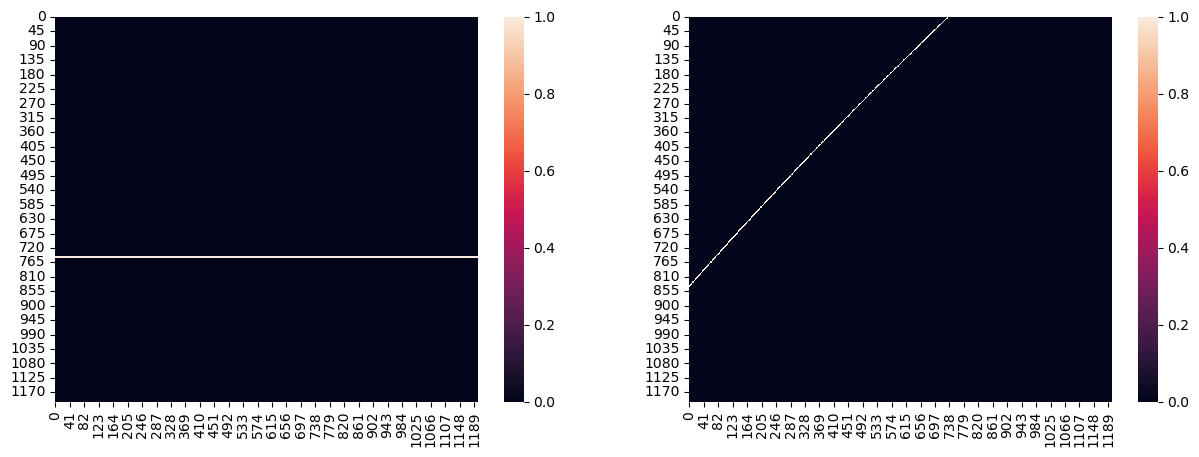

In [201]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.heatmap(mask_test_lat, ax=axes[0])
sns.heatmap(mask_test_lon, ax=axes[1])

In [202]:
(mask_test_lat & mask_test_lon).sum()

<xarray.DataArray ()> Size: 8B
array(29)

In [222]:
# Apply the mask to slice the dataset
sliced_ds = ds.where(mask, drop=True)

print("Sliced dataset info:")
print(sliced_ds)

Sliced dataset info:
<xarray.Dataset> Size: 50kB
Dimensions:           (YDim:MODIS_Grid_8Day_1km_LST: 18,
                       XDim:MODIS_Grid_8Day_1km_LST: 29)
Coordinates:
    lon               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 4kB ...
    lat               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 4kB ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables:
    LST_Day_1km       (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 4kB ...
    QC_Day            (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 2kB ...
    Day_view_time     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 4kB ...
    Day_view_angl     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 4kB ...
    LST_Night_1km     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 

In [223]:
# If you want to extract a specific variable:
variable_to_plot = 'LST_Day_1km'
sliced_data = sliced_ds[variable_to_plot]

print(f"\nSliced {variable_to_plot} data:")
print(sliced_data)

# Print the actual lat/lon bounds of the sliced data
print(f"\nActual bounds of sliced data:")
print(f"Latitude: {sliced_ds.lat.min().values} to {sliced_ds.lat.max().values}")
print(f"Longitude: {sliced_ds.lon.min().values} to {sliced_ds.lon.max().values}")



Sliced LST_Day_1km data:
<xarray.DataArray 'LST_Day_1km' (YDim:MODIS_Grid_8Day_1km_LST: 18,
                                 XDim:MODIS_Grid_8Day_1km_LST: 29)> Size: 4kB
array([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan, 301.16, 300.86,
        300.94, 301.14, 301.62, 301.12, 301.56, 301.82, 300.6 , 300.88,
        301.34, 302.14, 302.34, 300.94, 301.3 ],
       [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan, 300.94, 299.18, 299.26,
        301.1 , 300.18, 300.06, 300.64, 301.28, 300.62, 300.74, 301.62,
        301.76, 301.26, 301.16, 300.96,    nan],
       [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan, 299.3 , 299.08, 300.6 ,
        299.9 , 299.88, 300.46, 301.16, 300.74, 300.26, 300.72, 301.54,
        301.16, 301.02, 300.76, 300.84,    nan],
       [   nan,    nan,    nan,   

In [280]:
# Extract the data for the varaible to plot
variable_to_plot = "LST_Day_1km"
plot_df = sliced_ds[variable_to_plot].to_dataframe().reset_index()
plot_df['region'] = sliced_ds.attrs['region']
plot_df['date'] = row['start_time']#sliced_ds.attrs['start_date']#r
plot_df.isna().sum()/len(plot_df)


YDim:MODIS_Grid_8Day_1km_LST    0.000000
XDim:MODIS_Grid_8Day_1km_LST    0.000000
lon                             0.000000
lat                             0.000000
LST_Day_1km                     0.484674
region                          0.000000
date                            0.000000
dtype: float64

In [215]:
data_params

{'city_region_name': 'Atlanta, GA',
 'coordinates': {'rural': {'SW': [33.5, -84.6], 'NE': [33.55, -84.55]},
  'urban': {'SW': [33.73, -84.42], 'NE': [33.78, -84.37]}},
 'time': {'start': '2022-06-01', 'end': '2022-08-31'},
 'fips': {'state_fips': 'GA',
  'rural': {'state_fips': '13',
   'county_fips': ['13113'],
   'census_tract_fips': ['13113010100',
    '13113010200',
    '13113010300',
    '13113010400',
    '13113010500']},
  'urban': {'state_fips': '13',
   'county_fips': ['13121'],
   'census_tract_fips': ['13121000100',
    '13121000200',
    '13121000300',
    '13121000400',
    '13121000500']}}}

In [218]:

fig = px.scatter_mapbox(plot_df,  lat="lat", lon="lon", color=variable_to_plot,mapbox_style='open-street-map',
                        color_continuous_scale="")#, zoom=10, height=600, width=800)

# Reduce marker size
fig.update_traces(marker=dict(size=3))


In [253]:
def save_coordinates(ds, verbose=True):
    """
    Save the coordinates of a dataset.
    Parameters:
    - ds (xarray.Dataset): The dataset containing the data.
    - verbose (bool): Whether to print additional information. Default is True.
    Returns:
    - xarray.Dataset: The dataset with added latitude and longitude coordinates.
    """
    # Rest of the code...
    # Step 2: Parse the StructMetadata.0 attribute
    metadata = ds.attrs['StructMetadata.0']

    # Extract relevant information using regex
    upper_left = re.search(r'UpperLeftPointMtrs=\((.*?)\)', metadata).group(1).split(',')
    lower_right = re.search(r'LowerRightMtrs=\((.*?)\)', metadata).group(1).split(',')
    dims = re.search(r'XDim=(\d+)\s+YDim=(\d+)', metadata)#.group(1)
    if verbose:
        print(f"{upper_left=}, {lower_right=}, {dims=}")

    upper_left_x, upper_left_y = map(float, upper_left)
    lower_right_x, lower_right_y = map(float, lower_right)
    x_dim, y_dim = map(int, dims.groups())

    # Step 3: Define the projection
    proj_params_match = re.search(r'ProjParams=\((.*?)\)', ds.attrs['StructMetadata.0'])
    proj_params_str = proj_params_match.group(1)
    proj_params = list(map(float, proj_params_str.split(',')))
    modis_sinu_regex = Proj(proj='sinu', R=proj_params[0], x_0=proj_params[8])
    if verbose:
        print(modis_sinu_regex.definition)
        
    # Step 3: Set up projections
    modis_sinu = CRS.from_string(modis_sinu_regex.definition)#'+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m')
    if verbose:
        print(modis_sinu_regex.definition)
    wgs84 = CRS.from_epsg(4326)

    # Step 4: Create coordinate arrays
    x = np.linspace(upper_left_x, lower_right_x, x_dim)
    y = np.linspace(upper_left_y, lower_right_y, y_dim)

    
    # Step 5: Create a mesh grid of coordinates
    xx, yy = np.meshgrid(x, y)

    # Step 6: Transform coordinates to lat/lon
    transformer = Transformer.from_crs(modis_sinu, wgs84, always_xy=True)
    lons, lats = transformer.transform(xx, yy)

    if verbose:
        print(f"Longitude range: {lons.min()} to {lons.max()}")
        print(f"Latitude range: {lats.min()} to {lats.max()}")

    # Step 8: Add rounded lat/lon coordinates to the dataset
    ds = ds.assign_coords(lon=(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lons),
                        lat=(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lats))

    return ds

In [254]:
def slice_coordinates(ds, sw_lat=None, sw_lon=None, ne_lat=None, ne_lon=None,
                                            data_params=None, region_name=None, tolerance=0.05, verbose=True):
    """
    Slice a dataset based on the given bounding box coordinates or region name.
    Parameters:
        - ds (xarray.Dataset): The dataset to be sliced.
        - sw_lat (float, optional): The latitude of the southwest corner of the bounding box. Default is None.
        - sw_lon (float, optional): The longitude of the southwest corner of the bounding box. Default is None.
        - ne_lat (float, optional): The latitude of the northeast corner of the bounding box. Default is None.
        - ne_lon (float, optional): The longitude of the northeast corner of the bounding box. Default is None.
        - data_params (dict, optional): A dictionary containing the bounding box coordinates for different regions. Default is None.
        - region_name (str, optional): The name of the region to be sliced. Required if data_params is provided. Default is None.
        - tolerance (float, optional): The tolerance value for expanding the bounding box. Default is 0.05.
        - verbose (bool, optional): Whether to print verbose output. Default is True.
    Returns:
        - sliced_ds (xarray.Dataset): The sliced dataset based on the given bounding box or region.
    Raises:
        - ValueError: If neither the bounding box coordinates nor the data_params dictionary is provided.
        - ValueError: If the region name is not provided when data_params is provided.
    """
    
    
    if (sw_lat is None) or (sw_lon is None) or (ne_lat is None) or (ne_lon is None):
        if data_params is None:
            raise ValueError("Please provide either the bounding box coordinates or the data_params dictionary.")
        if region_name is None:
            raise ValueError("Please provide the region name from the data_params dictionary.")
        
        # Define your bounding box (SW and NE corners)
        sw_lat, sw_lon = data_params['coordinates'][region_name]['SW']
        ne_lat, ne_lon = data_params['coordinates'][region_name]['NE']

    # Create a boolean mask for the bounding box
    mask = (
        (ds.lat >= sw_lat-tolerance) & 
        (ds.lat <= ne_lat+tolerance) & 
        (ds.lon >= sw_lon-tolerance) & 
        (ds.lon <= ne_lon+tolerance)
    )
    
    if verbose:
        print(f"{sw_lat-tolerance=}, {ne_lat+tolerance=}, {sw_lon-tolerance=}, {ne_lon+tolerance=}")
        print(mask.sum().item())
        
    # Apply the mask to slice the dataset
    sliced_ds = ds.where(mask, drop=True)

    return sliced_ds

#### Extracting date

In [255]:
ds.attrs.keys()

dict_keys(['HDFEOSVersion', 'StructMetadata.0', 'identifier_product_doi', 'identifier_product_doi_authority', 'CoreMetadata.0', 'ArchiveMetadata.0', 'region'])

In [256]:
# print(ds.attrs['StructMetadata.0'])

In [257]:
import re
from datetime import datetime
import xarray as xr
import numpy as np

core_metadata = ds.attrs['CoreMetadata.0']
print(core_metadata)


GROUP                  = INVENTORYMETADATA
  GROUPTYPE            = MASTERGROUP

  GROUP                  = ECSDATAGRANULE

    OBJECT                 = LOCALGRANULEID
      NUM_VAL              = 1
      VALUE                = "MOD11A2.A2022241.h11v05.061.2022251144103.hdf"
    END_OBJECT             = LOCALGRANULEID

    OBJECT                 = PRODUCTIONDATETIME
      NUM_VAL              = 1
      VALUE                = "2022-09-08T14:41:03.000Z"
    END_OBJECT             = PRODUCTIONDATETIME

    OBJECT                 = DAYNIGHTFLAG
      NUM_VAL              = 1
      VALUE                = "Both"
    END_OBJECT             = DAYNIGHTFLAG

    OBJECT                 = REPROCESSINGACTUAL
      NUM_VAL              = 1
      VALUE                = "reprocessed"
    END_OBJECT             = REPROCESSINGACTUAL

    OBJECT                 = LOCALVERSIONID
      NUM_VAL              = 1
      VALUE                = "6.3.0"
    END_OBJECT             = LOCALVERSIONID

    OBJECT    

In [258]:
# Regular expression pattern to capture the multi-line group
pattern = re.compile(r'GROUP\s+=\s+RANGEDATETIME(.*?)END_GROUP\s+=\s+RANGEDATETIME', re.DOTALL)
pattern

re.compile(r'GROUP\s+=\s+RANGEDATETIME(.*?)END_GROUP\s+=\s+RANGEDATETIME',
           re.DOTALL|re.UNICODE)

In [259]:
# Extract the matched group
match = pattern.search(core_metadata)
print(match.group(0))

GROUP                  = RANGEDATETIME

    OBJECT                 = RANGEENDINGDATE
      NUM_VAL              = 1
      VALUE                = "2022-09-05"
    END_OBJECT             = RANGEENDINGDATE

    OBJECT                 = RANGEENDINGTIME
      NUM_VAL              = 1
      VALUE                = "23:59:59"
    END_OBJECT             = RANGEENDINGTIME

    OBJECT                 = RANGEBEGINNINGDATE
      NUM_VAL              = 1
      VALUE                = "2022-08-29"
    END_OBJECT             = RANGEBEGINNINGDATE

    OBJECT                 = RANGEBEGINNINGTIME
      NUM_VAL              = 1
      VALUE                = "00:00:00"
    END_OBJECT             = RANGEBEGINNINGTIME

  END_GROUP              = RANGEDATETIME


In [260]:
## VIEWING ENTIRE GROUP FOR RANGEDATETIME
# Regular expression pattern to capture the multi-line group
# pattern = re.compile(r'GROUP\s+=\s+RANGEDATETIME(.*?)END_GROUP\s+=\s+RANGEDATETIME', re.DOTALL)
pattern = re.compile(r'GROUP\s+=\s+RANGEDATETIME(?:\n|.)*?END_GROUP\s+=\s+RANGEDATETIME')


# Extract the matched group
match = pattern.search(core_metadata)
print(match.group(0))

GROUP                  = RANGEDATETIME

    OBJECT                 = RANGEENDINGDATE
      NUM_VAL              = 1
      VALUE                = "2022-09-05"
    END_OBJECT             = RANGEENDINGDATE

    OBJECT                 = RANGEENDINGTIME
      NUM_VAL              = 1
      VALUE                = "23:59:59"
    END_OBJECT             = RANGEENDINGTIME

    OBJECT                 = RANGEBEGINNINGDATE
      NUM_VAL              = 1
      VALUE                = "2022-08-29"
    END_OBJECT             = RANGEBEGINNINGDATE

    OBJECT                 = RANGEBEGINNINGTIME
      NUM_VAL              = 1
      VALUE                = "00:00:00"
    END_OBJECT             = RANGEBEGINNINGTIME

  END_GROUP              = RANGEDATETIME


In [261]:
# Regular expressions to extract date and time
start_date_pattern = re.compile(r'RANGEBEGINNINGDATE.*?VALUE\s+=\s"(.*?)"', re.DOTALL)
start_time_pattern = re.compile(r'RANGEBEGINNINGTIME.*?VALUE\s+=\s+"(.*?)"', re.DOTALL)

# Extract dates and times
beginning_date = start_date_pattern.search(core_metadata).group(1)# Group 1 is first match, 0 is full string
beginning_time = start_time_pattern.search(core_metadata).group(1) 

# Convert to datetime
beginning_datetime = datetime.strptime(f"{beginning_date} {beginning_time}", "%Y-%m-%d %H:%M:%S")
print(beginning_datetime)



2022-08-29 00:00:00


In [262]:
# Repeat process for ending date/time
end_date_pattern = re.compile(r'RANGEENDINGDATE.*?VALUE\s+=\s+"(.*?)"', re.DOTALL)
end_time_pattern = re.compile(r'RANGEENDINGTIME.*?VALUE\s+=\s+"(.*?)"', re.DOTALL)

# Extract dates and times
ending_date = end_date_pattern.search(core_metadata).group(1)#1
ending_time = end_time_pattern.search(core_metadata).group(1)#1

# Convert to datetime
ending_datetime = datetime.strptime(f"{ending_date} {ending_time}", "%Y-%m-%d %H:%M:%S")
print(ending_datetime)


2022-09-05 23:59:59


In [263]:
# ## Adding the start and end time as coordinates to the dataset
# ds = ds.expand_dims({"start_time":[beginning_datetime],
#                      "end_time":[ending_datetime]})
# print(ds)

In [265]:
def extract_times_from_metadata(ds, as_dim=False):
    """
    Extracts the start and end times from the metadata of a dataset.
    Parameters:
    - ds: xarray.Dataset
        The dataset containing the metadata.
    - as_dim: bool, optional
        If True, the dataset will be expanded with the start time as a new dimension.
    Returns:
    - ds: xarray.Dataset
        The dataset with the start and end times added as attributes.
        If as_dim is True, the dataset will also have the start time as a new dimension.
    """
    import re
    from datetime import datetime

    core_metadata = ds.attrs['CoreMetadata.0']
    # Regular expressions to extract date and time
    start_date_pattern = re.compile(r'RANGEBEGINNINGDATE.*?VALUE\s+=\s"(.*?)"', re.DOTALL)
    start_time_pattern = re.compile(r'RANGEBEGINNINGTIME.*?VALUE\s+=\s+"(.*?)"', re.DOTALL)

    # Extract dates and times
    beginning_date = start_date_pattern.search(core_metadata).group(1)# Group 1 is first match, 0 is full string
    beginning_time = start_time_pattern.search(core_metadata).group(1) 

    # Convert to datetime
    beginning_datetime = datetime.strptime(f"{beginning_date} {beginning_time}", "%Y-%m-%d %H:%M:%S")

    # Repeat process for ending date/time
    end_date_pattern = re.compile(r'RANGEENDINGDATE.*?VALUE\s+=\s+"(.*?)"', re.DOTALL)
    end_time_pattern = re.compile(r'RANGEENDINGTIME.*?VALUE\s+=\s+"(.*?)"', re.DOTALL)

    # Extract dates and times
    ending_date = end_date_pattern.search(core_metadata).group(1)#1
    ending_time = end_time_pattern.search(core_metadata).group(1)#1

    # Convert to datetime
    ending_datetime = datetime.strptime(f"{ending_date} {ending_time}", "%Y-%m-%d %H:%M:%S")
    
    ### TO DO: Try adding as attrs first
    ## Adding the start and end time as coordinates to the dataset
    ds.attrs['start_time'] = beginning_datetime
    ds.attrs['end_time'] = ending_datetime
    
    if as_dim:
        ds = ds.expand_dims({"start_time":[beginning_datetime]})
    return ds

In [294]:
def load_data(hdf_fname, data_params, region_name, time_as_dim=False, slice=False,slice_tolerance=.05, verbose=False):
    """
    Load data from an HDF file and perform various data processing steps.
    Parameters:
    - hdf_fname (str): The file path of the HDF file.
    - data_params (dict): A dictionary containing data parameters.
    - region_name (str): The name of the region.
    - time_as_dim (bool): Whether to treat time as a dimension (default: False).
    - slice (bool): Whether to slice the data based on coordinates (default: False).
    - slice_tolerance (float): The tolerance for slicing coordinates (default: 0.05).
    - verbose (bool): Whether to display verbose output (default: True).
    Returns:
    - x_data (xarray.Dataset): The processed dataset.
    """
    
    # Open the dataset
    x_data = xr.open_dataset(hdf_fname, engine='netcdf4')

    
    ## Convert the temperature from Kelvin to Celsius and Fahrenheit
    x_data = convert_temp_in_array(x_data, verbose=verbose)
    
    # Save the coordinates from data params
    coordinate_dict = data_params['coordinates'][region_name]
    sw_lat,sw_lon = coordinate_dict['SW']
    ne_lat,ne_lon = coordinate_dict['NE']
    
    # x_data = save_coordinates(x_data, lat1, lat2, lon1, lon2)
    x_data = save_coordinates(x_data, 
                              #data_params, region_name, 
                              verbose=verbose)

    ## Save the group name
    x_data = x_data.expand_dims(region=[region_name])
    
    ## Add time as a coords
    x_data = extract_times_from_metadata(x_data,as_dim=time_as_dim)
    
    ## TO DO: Decide if time should be saved as a coordinate or attribute
    


    if slice:
        x_data = slice_coordinates(x_data, sw_lat=sw_lat, sw_lon=sw_lon, ne_lat=ne_lat, ne_lon=ne_lon,
                                #    data_params, region_name, 
                                   tolerance=slice_tolerance, verbose=verbose)
    return x_data
    duplicate_arrays.append(x_data)
    

In [283]:
files_df.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,...,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE,lat_range,lon_range
fname,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022145.h10v05.061.2022158004240,rural,G2287415233-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-05-25T00:00:00.000Z,2022-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022145.h10v05.061.2022158004240,2022-06-06T19:53:48.253Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022153.h10v05.061.2022162062051,rural,G2289693385-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-02T00:00:00.000Z,2022-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022153.h10v05.061.2022162062051,2022-06-11T01:37:38.435Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022161.h10v05.061.2022170051101,rural,G2298462831-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-10T00:00:00.000Z,2022-06-17T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022161.h10v05.061.2022170051101,2022-06-19T01:10:28.925Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022169.h10v05.061.2022178215233,rural,G2312389316-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-18T00:00:00.000Z,2022-06-25T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022169.h10v05.061.2022178215233,2022-06-28T07:50:06.694Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"
./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022177.h10v05.061.2022186043527,rural,G2322872080-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-26T00:00:00.000Z,2022-07-03T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A202...,MOD11A2.A2022177.h10v05.061.2022186043527,2022-07-05T01:21:48.382Z,...,05,51010005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -92.388605818441)","(30.0041666666667, -80.8406494782854)","(39.9958333333333, -104.438013067114)","(39.9958333333333, -91.3839615039452)","[30.0041666666667, 39.9958333333333]","[-92.388605818441, -91.3839615039452]"


In [284]:
i = 0
row = files_df.iloc[i]

x0 = load_data(row['.hdf_file'], data_params,row['region'],
                           verbose=False, time_as_dim=True, slice=False)
print(x0)

<xarray.Dataset> Size: 161MB
Dimensions:           (start_time: 1, region: 1,
                       YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Coordinates:
  * start_time        (start_time) datetime64[ns] 8B 2022-05-25
  * region            (region) object 8B 'rural'
    lon               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    lat               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Da

In [285]:

x0_sliced = load_data(files_df['.hdf_file'].iloc[i], data_params, files_df['region'].iloc[i],
                                  verbose=False, slice=True)
print(x0_sliced)

<xarray.Dataset> Size: 8B
Dimensions:           (region: 1, YDim:MODIS_Grid_8Day_1km_LST: 0,
                       XDim:MODIS_Grid_8Day_1km_LST: 0)
Coordinates:
  * region            (region) object 8B 'rural'
    lon               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    lat               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    QC_Day            (region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 0B ...
    Day_view_time     (region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    Day_view_angl     (region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    LST_Night_1km     

In [286]:
x0['LST_Day_1km_F']

<xarray.DataArray 'LST_Day_1km_F' (start_time: 1, region: 1,
                                   YDim:MODIS_Grid_8Day_1km_LST: 1200,
                                   XDim:MODIS_Grid_8Day_1km_LST: 1200)> Size: 12MB
array([[[[93.47 , 90.734, 91.382, ...,    nan,    nan,    nan],
         [91.094, 91.706, 92.678, ...,    nan,    nan,    nan],
         [94.046, 95.522, 98.078, ...,    nan,    nan,    nan],
         ...,
         [89.33 , 89.798, 89.186, ...,    nan,    nan,    nan],
         [88.898, 89.51 , 89.15 , ...,    nan,    nan,    nan],
         [88.322, 88.934, 89.078, ...,    nan,    nan,    nan]]]])
Coordinates:
  * start_time  (start_time) datetime64[ns] 8B 2022-05-25
  * region      (region) object 8B 'rural'
    lon         (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    lat         (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Attributes:
    units:        Fahrenheit
    description:  Land Surface Temperature in Fahrenheit

In [287]:
x0_sliced['LST_Day_1km_F']

<xarray.DataArray 'LST_Day_1km_F' (region: 1, YDim:MODIS_Grid_8Day_1km_LST: 0,
                                   XDim:MODIS_Grid_8Day_1km_LST: 0)> Size: 0B
array([], shape=(1, 0, 0), dtype=float64)
Coordinates:
  * region   (region) object 8B 'rural'
    lon      (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    lat      (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Attributes:
    units:        Fahrenheit
    description:  Land Surface Temperature in Fahrenheit

In [288]:
file_list_dict = files_df.groupby('region')['.hdf_file'].apply(list).to_dict()
file_list_dict

{'rural': ['./data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022145.h10v05.061.2022158004240.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022153.h10v05.061.2022162062051.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022161.h10v05.061.2022170051101.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022169.h10v05.061.2022178215233.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022177.h10v05.061.2022186043527.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022185.h10v05.061.2022194193358.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022193.h10v05.061.2022202055159.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022201.h10v05.061.2022215032817.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022209.h10v05.061.2022218035751.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022217.h10v05.061.2022232190131.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022225.h10v05.061.2022234232206.hdf',
  './data/MODIS-LST/Atlanta_GA/rural/MOD11A2.A2022233.h1

In [289]:
# Testing the load_data function on a single region
file_list = file_list_dict['rural']

rural_data = []
for file in file_list:
    x = load_data(file, data_params, 'rural')
    rural_data.append(x)

Updated Dataset:
 <xarray.Dataset> Size: 138MB
Dimensions:           (YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Day_view_angl     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    LST_Night_1km     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Night          (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    ...                ...
    Emis_31           (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS

In [290]:
date_dimension = np.array([x.attrs['start_time'] for x in rural_data])
date_dimension

array([datetime.datetime(2022, 5, 25, 0, 0),
       datetime.datetime(2022, 6, 2, 0, 0),
       datetime.datetime(2022, 6, 10, 0, 0),
       datetime.datetime(2022, 6, 18, 0, 0),
       datetime.datetime(2022, 6, 26, 0, 0),
       datetime.datetime(2022, 7, 4, 0, 0),
       datetime.datetime(2022, 7, 12, 0, 0),
       datetime.datetime(2022, 7, 20, 0, 0),
       datetime.datetime(2022, 7, 28, 0, 0),
       datetime.datetime(2022, 8, 5, 0, 0),
       datetime.datetime(2022, 8, 13, 0, 0),
       datetime.datetime(2022, 8, 21, 0, 0),
       datetime.datetime(2022, 8, 29, 0, 0)], dtype=object)

In [291]:
print(rural_data[0])

<xarray.Dataset> Size: 161MB
Dimensions:           (region: 1, YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Coordinates:
  * region            (region) object 8B 'rural'
    lon               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    lat               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Day_view_angl     (region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
  

In [35]:
# date_dimension = np.array([x['start_time'].values for x in rural_data])
# date_dimension

In [306]:
ds_rural = xr.concat(rural_data, dim='start_time')

## not sure if needed to use original start_time
# ds_rural = ds_rural.assign_coords(start_time=date_dimension)
ds_rural = ds_rural.assign_coords(start_time=('start_time',date_dimension)) 

print(ds_rural)

<xarray.Dataset> Size: 2GB
Dimensions:           (start_time: 13, region: 1,
                       YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Coordinates:
  * region            (region) object 8B 'rural'
    lon               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    lat               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
  * start_time        (start_time) datetime64[ns] 104B 2022-05-25 ... 2022-08-29
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 150MB ...
    QC_Day            (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 75MB ...
    Day_view_time     (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, X

In [310]:
print(ds_rural['LST_Day_1km_F'])

<xarray.DataArray 'LST_Day_1km_F' (start_time: 13, region: 1,
                                   YDim:MODIS_Grid_8Day_1km_LST: 1200,
                                   XDim:MODIS_Grid_8Day_1km_LST: 1200)> Size: 150MB
array([[[[ 93.47 ,  90.734,  91.382, ...,     nan,     nan,     nan],
         [ 91.094,  91.706,  92.678, ...,     nan,     nan,     nan],
         [ 94.046,  95.522,  98.078, ...,     nan,     nan,     nan],
         ...,
         [ 89.33 ,  89.798,  89.186, ...,     nan,     nan,     nan],
         [ 88.898,  89.51 ,  89.15 , ...,     nan,     nan,     nan],
         [ 88.322,  88.934,  89.078, ...,     nan,     nan,     nan]]],


       [[[ 95.99 ,  95.774,  96.17 , ...,  80.402,  80.582,  85.37 ],
         [ 96.026,  96.746,  98.078, ...,  80.798,  85.658,  85.586],
         [ 98.546, 100.382, 100.598, ...,  86.594,  86.45 ,  85.55 ],
         ...,
         [ 84.794,  84.902,  85.37 , ...,     nan,     nan,     nan],
         [ 84.146,  84.938,  85.586, ...,     nan, 

In [315]:
df_rural = ds_rural['LST_Day_1km_F'].to_dataframe().reset_index()
df_rural


,start_time,region,YDim:MODIS_Grid_8Day_1km_LST,XDim:MODIS_Grid_8Day_1km_LST,lon,lat,LST_Day_1km_F
0,2022-05-25,rural,0,0,-105.446902,40.0,93.470
1,2022-05-25,rural,0,1,-105.436014,40.0,90.734
2,2022-05-25,rural,0,2,-105.425127,40.0,91.382
3,2022-05-25,rural,0,3,-105.414239,40.0,92.858
4,2022-05-25,rural,0,4,-105.403352,40.0,94.154
...,...,...,...,...,...,...,...
18719995,2022-08-29,rural,1199,1195,-81.764777,30.0,NaN
18719996,2022-08-29,rural,1199,1196,-81.755147,30.0,NaN
18719997,2022-08-29,rural,1199,1197,-81.745516,30.0,NaN
18719998,2022-08-29,rural,1199,1198,-81.735886,30.0,NaN


In [322]:
# Filter the data based on the bounding box coordinates
filter_lon = (df_rural['lon'] >= data_params['coordinates']['rural']['SW'][1]) \
                & (df_rural['lon'] <= data_params['coordinates']['rural']['NE'][1])
filter_lat = (df_rural['lat'] >= data_params['coordinates']['rural']['SW'][0]) \
                & (df_rural['lat'] <= data_params['coordinates']['rural']['NE'][0])
filter_lon.sum(), filter_lat.sum()

(25415, 93600)

In [323]:
# Combining filters
df_rural[filter_lon & filter_lat]

,start_time,region,YDim:MODIS_Grid_8Day_1km_LST,XDim:MODIS_Grid_8Day_1km_LST,lon,lat,LST_Day_1km_F


### Load sliced data

- Goal: use sliced data to construct a single xarray per date per region
- The use convert_to_dataframe() to save as df
- Add region name and start date as columns.
- Concenat dfs for plotting

In [297]:
# Testing the load_data function on a single region
file_list = file_list_dict['rural']

rural_data_sliced = []
for file in file_list:
    x = load_data(file, data_params, 'rural', time_as_dim=True, slice=True)
    rural_data_sliced.append(x)
print(rural_data_sliced[0])

<xarray.Dataset> Size: 16B
Dimensions:           (start_time: 1, region: 1,
                       YDim:MODIS_Grid_8Day_1km_LST: 0,
                       XDim:MODIS_Grid_8Day_1km_LST: 0)
Coordinates:
  * start_time        (start_time) datetime64[ns] 8B 2022-05-25
  * region            (region) object 8B 'rural'
    lon               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    lat               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    QC_Day            (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 0B ...
    Day_view_time     (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) floa

In [298]:
%%time
ds_rural_sliced = xr.concat(rural_data_sliced, dim='start_time')#dim='time')
print(ds_rural_sliced)

<xarray.Dataset> Size: 112B
Dimensions:           (start_time: 13, region: 1,
                       YDim:MODIS_Grid_8Day_1km_LST: 0,
                       XDim:MODIS_Grid_8Day_1km_LST: 0)
Coordinates:
  * start_time        (start_time) datetime64[ns] 104B 2022-05-25 ... 2022-08-29
  * region            (region) object 8B 'rural'
    lon               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    lat               (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 0B ...
    QC_Day            (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 0B ...
    Day_view_time     (start_time, region, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid

### Original Work (Pre 08/06) continued

In [327]:
%%time
## THIS LOOP CRASHES THE KERNEL

# Loop to load all files
dataset_dict = {'urban':[],
                'rural':[]}
dates_dict = {'urban':[],
              'rural':[]}
for group, file_list in file_list_dict.items():
    
    group_dates = []
    for fpath in file_list:
        x = load_data(fpath, data_params, group, time_as_dim=True, slice=False)
        
        group_dates.append(x.attrs['start_time'])
        dataset_dict[group].append(x)

    ## Save date dimension
    date_dimension = np.array(group_dates)
    dates_dict[group] = date_dimension
    
# Combine all the datasets into a single dataset
ds_rural = xr.concat(dataset_dict['rural'], dim='start_time') #'time'
# ds_rural = ds_rural.assign_coords(start_time=dates_dict['rural'])
ds_urban = xr.concat(dataset_dict['urban'], dim='start_time') #'time'
# ds_urban = ds_urban.assign_coords(start_time=dates_dict['urban'])

# len(dataset_dict['rural']), len(dataset_dict['urban'])
ds_urban['LST_Day_1km_F'].shape, ds_rural['LST_Day_1km_F'].shape


CPU times: user 9.04 s, sys: 2.75 s, total: 11.8 s
Wall time: 13.1 s


((26, 1, 1200, 1200), (13, 1, 1200, 1200))

In [328]:
ds_urban.start_time

<xarray.DataArray 'start_time' (start_time: 26)> Size: 208B
array(['2022-05-25T00:00:00.000000000', '2022-05-25T00:00:00.000000000',
       '2022-06-02T00:00:00.000000000', '2022-06-02T00:00:00.000000000',
       '2022-06-10T00:00:00.000000000', '2022-06-10T00:00:00.000000000',
       '2022-06-18T00:00:00.000000000', '2022-06-18T00:00:00.000000000',
       '2022-06-26T00:00:00.000000000', '2022-06-26T00:00:00.000000000',
       '2022-07-04T00:00:00.000000000', '2022-07-04T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-20T00:00:00.000000000', '2022-07-20T00:00:00.000000000',
       '2022-07-28T00:00:00.000000000', '2022-07-28T00:00:00.000000000',
       '2022-08-05T00:00:00.000000000', '2022-08-05T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-13T00:00:00.000000000',
       '2022-08-21T00:00:00.000000000', '2022-08-21T00:00:00.000000000',
       '2022-08-29T00:00:00.000000000', '2022-08-29T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * start_time  (start_time) datetime64[ns] 208B 2022-05-25 ... 2022-08-29

In [60]:
x0.attrs.keys()

dict_keys(['HDFEOSVersion', 'StructMetadata.0', 'identifier_product_doi', 'identifier_product_doi_authority', 'CoreMetadata.0', 'ArchiveMetadata.0', 'start_time', 'end_time'])

In [67]:
files_df.iloc[:2]

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,...,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE,lat_range,lon_range
fname,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2022145.h11v05.061.2022158004402,urban,G2287415355-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-05-25T00:00:00.000Z,2022-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...,MOD11A2.A2022145.h11v05.061.2022158004402,2022-06-06T19:53:55.155Z,...,05,51011005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)","[30.0041666666667, 39.9958333333333]","[-80.8406302319072, -78.329888184268]"
./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A2022153.h11v05.061.2022162064335,urban,G2289700971-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivit...,2022-06-02T00:00:00.000Z,2022-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...,./data/MODIS-LST/Atlanta_GA/urban/MOD11A2.A202...,MOD11A2.A2022153.h11v05.061.2022162064335,2022-06-11T01:57:48.539Z,...,05,51011005,10.5067/MODIS/MOD11A2.061,http://dx.doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)","[30.0041666666667, 39.9958333333333]","[-80.8406302319072, -78.329888184268]"


In [65]:
x1 = xr.open_dataset(files_df['.hdf_file'].iloc[1], engine='netcdf4')
print(x1)

<xarray.Dataset> Size: 115MB
Dimensions:           (YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables:
    LST_Day_1km       (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Day            (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Day_view_time     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Day_view_angl     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    LST_Night_1km     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    QC_Night          (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 6MB ...
    Night_view_time   (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float64 12MB ...
    Night_view_a

In [63]:
x0.attrs['CoreMetadata.0']

'\nGROUP                  = INVENTORYMETADATA\n  GROUPTYPE            = MASTERGROUP\n\n  GROUP                  = ECSDATAGRANULE\n\n    OBJECT                 = LOCALGRANULEID\n      NUM_VAL              = 1\n      VALUE                = "MOD11A2.A2022145.h11v05.061.2022158004402.hdf"\n    END_OBJECT             = LOCALGRANULEID\n\n    OBJECT                 = PRODUCTIONDATETIME\n      NUM_VAL              = 1\n      VALUE                = "2022-06-07T00:44:02.000Z"\n    END_OBJECT             = PRODUCTIONDATETIME\n\n    OBJECT                 = DAYNIGHTFLAG\n      NUM_VAL              = 1\n      VALUE                = "Both"\n    END_OBJECT             = DAYNIGHTFLAG\n\n    OBJECT                 = REPROCESSINGACTUAL\n      NUM_VAL              = 1\n      VALUE                = "reprocessed"\n    END_OBJECT             = REPROCESSINGACTUAL\n\n    OBJECT                 = LOCALVERSIONID\n      NUM_VAL              = 1\n      VALUE                = "6.3.0"\n    END_OBJECT             = 

In [66]:
x1.attrs['CoreMetadata.0']

'\nGROUP                  = INVENTORYMETADATA\n  GROUPTYPE            = MASTERGROUP\n\n  GROUP                  = ECSDATAGRANULE\n\n    OBJECT                 = LOCALGRANULEID\n      NUM_VAL              = 1\n      VALUE                = "MOD11A2.A2022153.h11v05.061.2022162064335.hdf"\n    END_OBJECT             = LOCALGRANULEID\n\n    OBJECT                 = PRODUCTIONDATETIME\n      NUM_VAL              = 1\n      VALUE                = "2022-06-11T06:43:35.000Z"\n    END_OBJECT             = PRODUCTIONDATETIME\n\n    OBJECT                 = DAYNIGHTFLAG\n      NUM_VAL              = 1\n      VALUE                = "Both"\n    END_OBJECT             = DAYNIGHTFLAG\n\n    OBJECT                 = REPROCESSINGACTUAL\n      NUM_VAL              = 1\n      VALUE                = "reprocessed"\n    END_OBJECT             = REPROCESSINGACTUAL\n\n    OBJECT                 = LOCALVERSIONID\n      NUM_VAL              = 1\n      VALUE                = "6.3.0"\n    END_OBJECT             = 

In [61]:
# ds_urban['LST_Day_1km_F'].shapea

In [62]:
# ds_rural['LST_Day_1km_F'].shape

In [47]:
# dataset_dict['rural'][0]['start_time'], dataset_dict['rural'][2]['start_time']

In [48]:
ds_rural['time'], ds_urban['time']

(<xarray.DataArray 'time' (time: 13)> Size: 104B
 array(['2022-05-25T00:00:00.000000000', '2022-06-02T00:00:00.000000000',
        '2022-06-10T00:00:00.000000000', '2022-06-18T00:00:00.000000000',
        '2022-06-26T00:00:00.000000000', '2022-07-04T00:00:00.000000000',
        '2022-07-12T00:00:00.000000000', '2022-07-20T00:00:00.000000000',
        '2022-07-28T00:00:00.000000000', '2022-08-05T00:00:00.000000000',
        '2022-08-13T00:00:00.000000000', '2022-08-21T00:00:00.000000000',
        '2022-08-29T00:00:00.000000000'], dtype='datetime64[ns]')
 Coordinates:
   * time     (time) datetime64[ns] 104B 2022-05-25 2022-06-02 ... 2022-08-29,
 <xarray.DataArray 'time' (time: 13)> Size: 104B
 array(['2022-05-25T00:00:00.000000000', '2022-06-02T00:00:00.000000000',
        '2022-06-10T00:00:00.000000000', '2022-06-18T00:00:00.000000000',
        '2022-06-26T00:00:00.000000000', '2022-07-04T00:00:00.000000000',
        '2022-07-12T00:00:00.000000000', '2022-07-20T00:00:00.000000000',
   

In [43]:
# ds_rural.sel(time=0)['start_time']

In [44]:
# ds_rural.sel(time=1)['start_time']

In [ ]:

# Combined dataset (added back)
ds = xr.concat([ds_rural, ds_urban], dim='time')


In [ ]:
def check_for_nans(df):
    # list of column names from the dataset
    ds_variable_columns = list(df.keys())
    # empty list that we will store dictionaries in
    all_time = []
    # empty list that we will store dataframes in
    all_time_df = []

    for i in range(df.sizes['time']):
        test_dict = {}
        for col in ds_variable_columns:
            loop_df = df[col].isel(time=i).to_dataframe().reset_index()
            temp_dict = {'Mean' : round(loop_df[col].isna().mean(), 4), 
                        'Sum': loop_df[col].isna().sum()}
            test_dict[col] = temp_dict
        all_time.append(test_dict)

    # transforming the dictionaries we created into dataframes and storing them into a list
    for i, test_dict in enumerate(all_time):
        temp_df = pd.DataFrame(test_dict)
        temp_df = temp_df.loc['Mean']
        temp_df.name = f"Time_{i+1}"
        all_time_df.append(temp_df)

    return pd.concat(all_time_df, axis=1)